# Extract the spectrum of the z=16 candidate in the CEERS field

Source identified by Donnan et al. (2022), Naidu et al. (2022), and others.

NIRSpec data from DD-2750 (PI: Pablo Arrabal Haro), obtained 24 March 2023.

*Pipeline steps*

1. Run the preprocessing pipline through extracting 2D cutouts
1. Drizzle the cutouts to a combined spectrum
1. Extract 1D spectrum
1. Fit redshift

In [1]:
# Are we on a GitHub codespace?
import os

if os.getcwd().startswith('/workspaces/msaexp'):
    import os
    os.environ['CRDS_PATH'] = os.path.join('/tmp/', 'crds_cache')

    if not os.path.exists(os.environ['CRDS_PATH']):
        ! mkdir {os.environ['CRDS_PATH']}

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

    print('On codespace: ', os.environ['CRDS_PATH'], os.environ['CRDS_SERVER_URL'])

    workdir  = '/workspaces/msaexp/docs/examples/codespace'
    if not os.path.exists(workdir):
        ! mkdir {workdir}
    
    os.chdir(workdir)
else:
    print('(not on a codespace)')

(not on a codespace)


In [2]:
import os
if 'CRDS_PATH' not in os.environ is None:
    os.environ['CRDS_PATH'] = f'{os.getcwd()}/crds_cache'

    if not os.path.exists(os.environ['CRDS_PATH']):
        os.makedirs(os.environ['CRDS_PATH'])

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

In [3]:
import os
import glob
import yaml
import warnings

import numpy as np
import matplotlib.pyplot as plt

import grizli
from grizli import utils, jwst_utils
jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy.io.fits as pyfits
from jwst.datamodels import SlitModel


import msaexp
from msaexp import pipeline

print(f'grizli version = {grizli.__version__}')
print(f'msaexp version = {msaexp.__version__}')

grizli version = 1.8.3
msaexp version = 0.6.6.dev10+g2df8a3b.d20230328


# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [4]:
# CEERS dropout
prog = 2750
gratings = ['prism']

outroot = 'ceers-ddt'
detectors = ['nrs1','nrs2']

file_version = 'v1'
src_rd = utils.read_catalog("""# name ra dec
naidu 214.914500 52.94304
# maisie 214.943153 52.942442
""")

if False:
    # RXJ2129 for testing
    prog = 2767
    detectors = ['nrs2']
    gratings = ['prism']

    outroot = 'rxj2129'
    src_rd = utils.read_catalog("""# ra dec
    322.4215529 0.0916869""")

    os.getcwd()
    
prog, src_rd

(2750,
 <GTable length=1>
  name    ra      dec   
  str5 float64  float64 
 ----- -------- --------
 naidu 214.9145 52.94304)

In [5]:
if 0:
    from grizli import jwst_level1
    
    files = glob.glob('*uncal.fits')
    files.sort()
    
    for file in files:
        log = file.replace('uncal.fits','uncal.log')
        if os.path.exists(log):
            continue
            
        _debug = jwst_level1.process_uncal_level1(file,
                                             output_extension='_rate',
                                             jump_threshold=4,
                                             erode_snowballs=4,
                                             grow_snowballs=5,
                                             rescale_uncertainty=True,
                                                  hot_thresh=[1000,90000]
                                            )


In [6]:
# Get preprocessed rate files, new rates from MAST have a bunch of NaN?

print('https://s3.amazonaws.com/grizli-v2/nirspec/ceers2750/rate/index.html')

files = glob.glob(f'jw0{prog}*rate.fits')

if len(files) == 0:
    ! aws s3 sync s3://grizli-v2/nirspec/ceers2750/rate/ ./ --exclude "*" --include "jw*rate.fits"

https://s3.amazonaws.com/grizli-v2/nirspec/ceers2750/rate/index.html


In [9]:
pipeline.download_msa_meta_files()

[]

In [10]:
import time

# Query NIRSpec data for a program name
files = glob.glob(f'jw0{prog}*rate.fits')

while len(files) == 0:
    print(time.ctime())
    masks = pipeline.query_program(prog, download=True, detectors=detectors, gratings=gratings,
                                   extensions=['uncal','s2d'])
    
    files = glob.glob(f'jw0{prog}*rate.fits')
    
    if len(files) == 0:
        time.sleep(30)

print(files)


['jw02750002001_03101_00003_nrs2_rate.fits', 'jw02750002001_07101_00002_nrs2_rate.fits', 'jw02750002001_05101_00002_nrs1_rate.fits', 'jw02750002001_05101_00003_nrs1_rate.fits', 'jw02750002001_07101_00003_nrs2_rate.fits', 'jw02750002001_03101_00002_nrs2_rate.fits', 'jw02750002001_05101_00001_nrs1_rate.fits', 'jw02750002001_07101_00001_nrs2_rate.fits', 'jw02750002001_03101_00001_nrs2_rate.fits', 'jw02750002001_07101_00001_nrs1_rate.fits', 'jw02750002001_05101_00001_nrs2_rate.fits', 'jw02750002001_03101_00001_nrs1_rate.fits', 'jw02750002001_03101_00003_nrs1_rate.fits', 'jw02750002001_05101_00002_nrs2_rate.fits', 'jw02750002001_07101_00002_nrs1_rate.fits', 'jw02750002001_07101_00003_nrs1_rate.fits', 'jw02750002001_05101_00003_nrs2_rate.fits', 'jw02750002001_03101_00002_nrs1_rate.fits']


# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [12]:
# Split into exposure sets
files = glob.glob(f'jw0{prog}*nrs?*rate.fits')
files.sort()

groups = {}
for i, k in enumerate(['03','05','07']):
    xgroups = pipeline.exposure_groups(files=files[i*6:(i+1)*6])
    for gk in xgroups:
        key = gk.replace('-01-cl', f'-01-{k}-cl')
        groups[key] = xgroups[gk]
        

print('\nFiles:\n======')
print(yaml.dump(dict(groups)))

   N  value     
====  ==========
   3  jw02750002001-01-clear-prism-nrs1
   3  jw02750002001-01-clear-prism-nrs2
   N  value     
====  ==========
   3  jw02750002001-01-clear-prism-nrs1
   3  jw02750002001-01-clear-prism-nrs2
   N  value     
====  ==========
   3  jw02750002001-01-clear-prism-nrs1
   3  jw02750002001-01-clear-prism-nrs2

Files:
jw02750002001-01-03-clear-prism-nrs1:
- jw02750002001_03101_00001_nrs1_rate.fits
- jw02750002001_03101_00002_nrs1_rate.fits
- jw02750002001_03101_00003_nrs1_rate.fits
jw02750002001-01-03-clear-prism-nrs2:
- jw02750002001_03101_00001_nrs2_rate.fits
- jw02750002001_03101_00002_nrs2_rate.fits
- jw02750002001_03101_00003_nrs2_rate.fits
jw02750002001-01-05-clear-prism-nrs1:
- jw02750002001_05101_00001_nrs1_rate.fits
- jw02750002001_05101_00002_nrs1_rate.fits
- jw02750002001_05101_00003_nrs1_rate.fits
jw02750002001-01-05-clear-prism-nrs2:
- jw02750002001_05101_00001_nrs2_rate.fits
- jw02750002001_05101_00002_nrs2_rate.fits
- jw02750002001_05101_000

## Preprocessing pipeline

1. Apply 1/f correction and identify "snowballs" on the `rate.fits` files
1. Remove "bias" (i.e., simple median) of each exposure
1. Rescale RNOISE array based on empty parts of the exposure
1. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
    - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
    - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
    - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
    - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
    - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
    - Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
1. Parse slit metadata
1. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

In [13]:
pipes = []

In [15]:
source_ids = None

# Subset from Arrabal-Haro et al.
source_ids = [0, 1,2,28,64,69,355,2763,3149]

# # All sources
# msa = msaexp.msa.MSAMetafile('jw02750002001_01_msa.fits')
# source_ids = list(np.unique(msa.shutter_table['source_id'][msa.shutter_table['primary_source'] == 'Y']))

for mode in groups:
    # Find the matching source
    pipe = pipeline.NirspecPipeline(mode=mode, files=groups[mode])

    idx, dr = src_rd.match_to_catalog_sky(pipe.msa.src_table)
    
    srcid = pipe.msa.src_table['source_id'][np.argmin(dr)]
    
    print(f'\n {mode} \n source_id: {srcid} dr={dr.min()}\n\n')

    # Run the pipeline to define slits, etc., but don't do extractions yet.  
    
    if 1:
        if not os.path.exists(f'{mode}.slits.yaml'):
            pipe = pipeline.NirspecPipeline(mode=mode,
                                            files=groups[mode],
                                            source_ids=source_ids,
                                            positive_ids=True # Ignore background slits
                                           ) 
            
            pipe.full_pipeline(run_extractions=False,
                               initialize_bkg=False,
                               load_saved=None,
                               scale_rnoise=False)
            
            pipes.append(pipe)
            
        else:
            print(f'Skip preprocessing: {pipe.mode}')

# (2023-03-28 14:36:37.391)
msaexp.NirspecPipeline: Initialize jw02750002001-01-03-clear-prism-nrs1
msaexp.NirspecPipeline: jw02750002001_03101_00001_nrs1_rate.fits
msaexp.NirspecPipeline: jw02750002001_03101_00002_nrs1_rate.fits
msaexp.NirspecPipeline: jw02750002001_03101_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02750002001-01-03-clear-prism-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02750002001_01_msa.fits

 jw02750002001-01-03-clear-prism-nrs1 
 source_id: 0 dr=0.12454352899953756 arcsec


Skip preprocessing: jw02750002001-01-03-clear-prism-nrs1
# (2023-03-28 14:36:37.612)
msaexp.NirspecPipeline: Initialize jw02750002001-01-03-clear-prism-nrs2
msaexp.NirspecPipeline: jw02750002001_03101_00001_nrs2_rate.fits
msaexp.NirspecPipeline: jw02750002001_03101_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02750002001_03101_00003_nrs2_rate.fits
msaexp.NirspecPipeline: mode=jw02750002001-01-03-clear-prism-nrs2 exp_type=NRS_MSASPEC  msametfl=jw02750002001_01_msa.fits

 jw02750002001-01-03

In [16]:
# Re-initialize by reading the saved slitlet files
targets = None

pipes = []

for mode in groups:
    
    if not os.path.exists(f'{mode}.slits.yaml'):
        continue
        
    pipe = pipeline.NirspecPipeline(mode=mode,
                                    files=groups[mode],
                                   ) 

    pipe.full_pipeline(run_extractions=False,
                       initialize_bkg=True,
                       load_saved='phot',
                       scale_rnoise=False,
                       targets=targets)

    #pipe.set_background_slits()
    print(f'\n\n {mode} {len(pipe.slitlets)} slitlets\n\n')
    
    if len(pipe.slitlets) > 0:
        pipes.append(pipe)


# (2023-03-28 14:36:47.523)
msaexp.NirspecPipeline: Initialize jw02750002001-01-03-clear-prism-nrs1
msaexp.NirspecPipeline: jw02750002001_03101_00001_nrs1_rate.fits
msaexp.NirspecPipeline: jw02750002001_03101_00002_nrs1_rate.fits
msaexp.NirspecPipeline: jw02750002001_03101_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02750002001-01-03-clear-prism-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02750002001_01_msa.fits
msaexp.read_data: jw02750002001_03101_00001_nrs1_phot.179.2750_2.fits 2750_2
msaexp.read_data: jw02750002001_03101_00001_nrs1_phot.209.2750_0.fits 2750_0
msaexp.read_data: jw02750002001_03101_00001_nrs1_phot.215.2750_3149.fits 2750_3149
msaexp.read_data: jw02750002001_03101_00001_nrs1_phot.220.2750_64.fits 2750_64
msaexp.read_data: jw02750002001_03101_00001_nrs1_phot.247.2750_2763.fits 2750_2763
msaexp.read_data: jw02750002001_03101_00001_nrs1_phot.255.2750_28.fits 2750_28
msaexp.read_data: jw02750002001_03101_00001_nrs1_phot.288.2750_355.fits 2750_355
msaexp.read_data: jw027

In [19]:
# All (extracted) target names
targets = []
for pipe in pipes:
    targets += list(pipe.slitlets.keys())

ii = -1

targets = np.unique(targets)
list(targets)

['2750_0',
 '2750_1',
 '2750_2',
 '2750_2763',
 '2750_28',
 '2750_3149',
 '2750_355',
 '2750_64',
 '2750_69']

# Background-subtracted slitlets

2023-03-28 16:37:39,680 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



2750_0
jw02750002001-01-03-clear-prism-nrs1 3
2750_0 not found in slitlets
jw02750002001-01-05-clear-prism-nrs1 3
2750_0 not found in slitlets
jw02750002001-01-07-clear-prism-nrs1 3
2750_0 not found in slitlets
0 9 2750_0 9


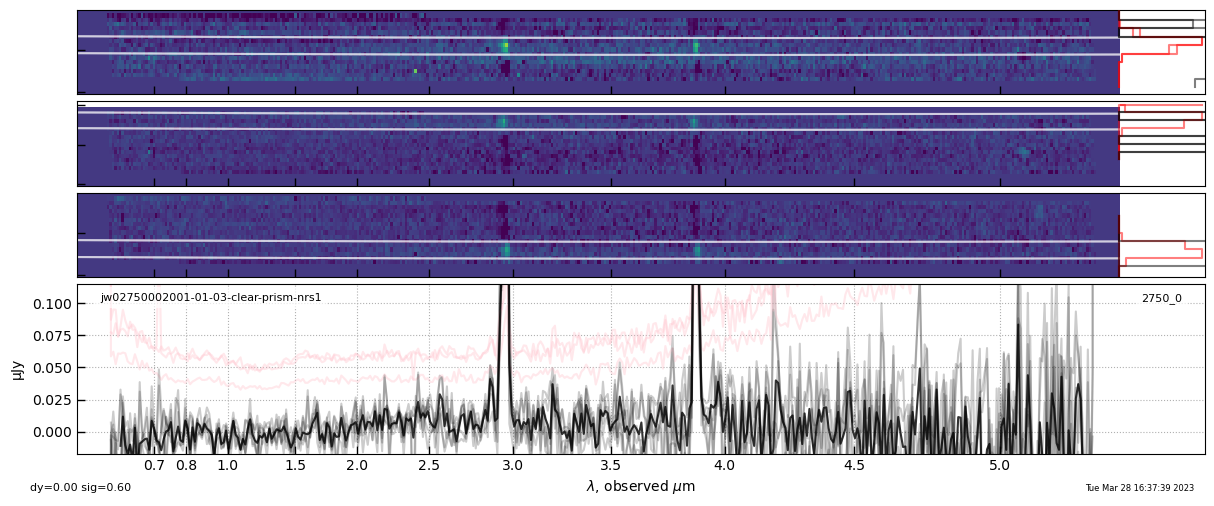

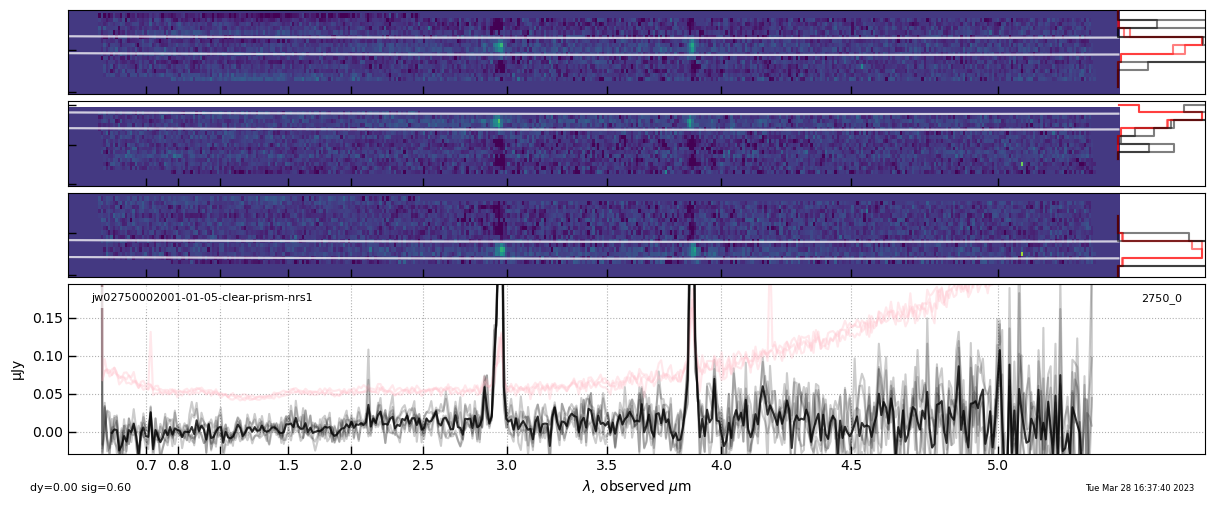

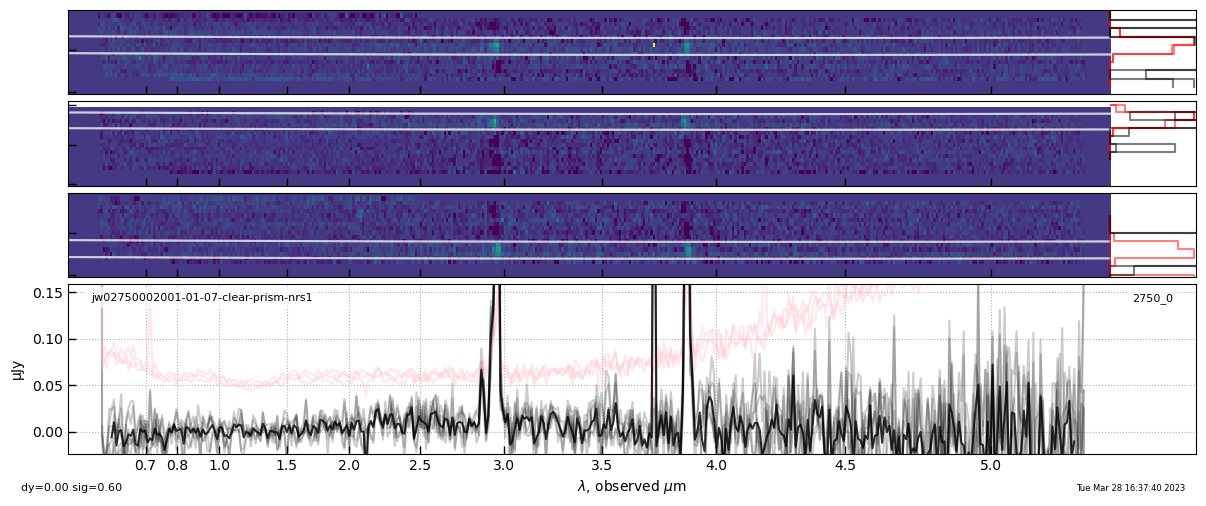

In [20]:
if 1:
    ii += 1
    key = targets[ii]
    
print(key)

slits = []

for pipe in pipes:
    try:
        _ = pipe.extract_spectrum(key, skip=[], yoffset=0., prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)
    except IndexError:
        print(f'\n ! Error: {pipe.mode} {key} ! \n')
        plt.close()
        continue
        
    slits_i = pipe.get_background_slits(key, step='bkg', check_background=True)
    if slits_i is not None:
        print(pipe.mode, len(slits_i))
        slits.extend(slits_i)
    
print(ii, len(targets), key, len(slits))

outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2750_0 read 9 files
msaexp.drizzle.drizzle_slitlets: id=2750_0  prism-clear N=9
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2750_0
msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2750_0                     0 -0.011 <SlitModel(20, 435) from jw02750002001_03101_00001_nrs1_phot.209.2750_0.fits> (20, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2750_0                     0  0.005 <SlitModel(20, 435) from jw02750002001_03101_00002_nrs1_phot.209.2750_0.fits> (20, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2750_0                     0 -0.027 <SlitModel(20, 435) from jw02750002001_03101_00003_nrs1_phot.209.2750_0.fits> (20, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  3 2750_0                     0 -0.011 <SlitModel(20, 435) from jw02750002001_05101_00001_nrs1_phot.209.2750_0.fits> (20, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  4 2750_0 

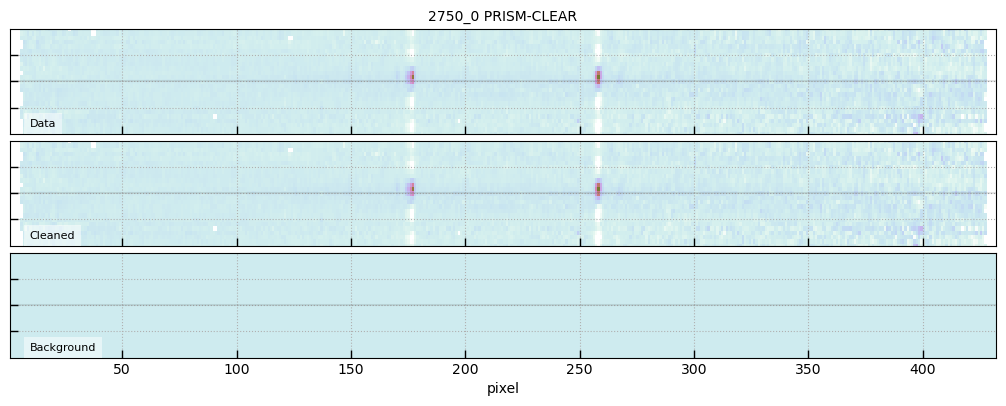

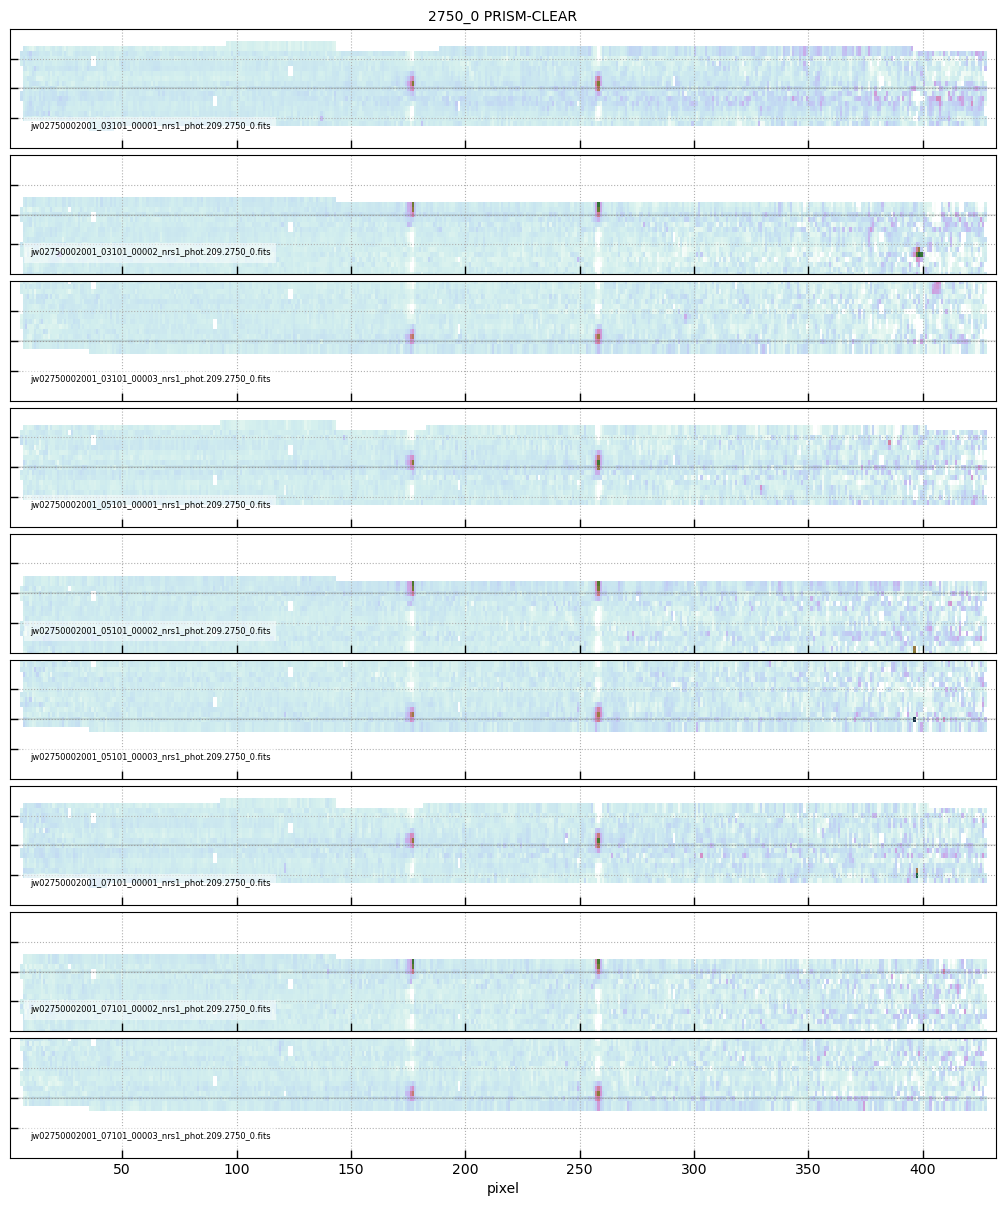

In [21]:
# Drizzle slitlets

import msaexp.drizzle
reload(msaexp.drizzle)


from importlib import reload
import copy

import msaexp.drizzle
reload(msaexp.drizzle); reload(msaexp.utils)
reload(msaexp.drizzle); reload(msaexp.utils) 

DRIZZLE_PARAMS = copy.deepcopy(msaexp.drizzle.DRIZZLE_PARAMS)
DRIZZLE_PARAMS['kernel'] = 'square'
DRIZZLE_PARAMS['pixfrac'] = 0.8

target = key

wave_sample = 1.05
master_bkg = 0

bkg_parity = []

wave_arrays = {}

if 0:
    # Use wavelength array from first slit
    wave_arrays = {}
    wave_arrays['prism-clear'] = msaexp.utils.get_slit_trace_wavelengths(slits[0])

# flexible outlier threshold
sn = slits[0].data / slits[0].err
outlier_threshold = np.clip(np.nanpercentile(sn[slits[0].err > 0], 90)*2, 7, 100)
# outlier_threshold = 1000

print('outlier_threshold: ', outlier_threshold)

if target == '2750_355':
    slits = slits[1:]
    
_ = msaexp.drizzle.drizzle_slitlets(target,
                                    output=outroot,
                                    files=slits,
                                    center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                    fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                    force_nypix=31,         # Y size of output array
                                    bkg_offset=6,           # Number of pixels to roll for background subtraction
                                    bkg_parity=bkg_parity,  # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                    master_bkg=master_bkg,
                                    log_step=False,         # Log wavelength steps
                                    outlier_threshold=outlier_threshold,   # Outlier rejection threshold
                                    err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                    show_drizzled=True,     # Figures
                                    show_slits=True,
                                    imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                    sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                    bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                    drizzle_params=DRIZZLE_PARAMS,
                                    wave_sample=wave_sample,
                                    wave_arrays=wave_arrays,
                                    center_phase=-0.5,
                                   )

figs, hdu_data, wavedata, all_slits, drz_data = _

msaexp.drizzle.extract_from_hdul: Initial center =  -0.95, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =  -0.07, sigma =   0.76


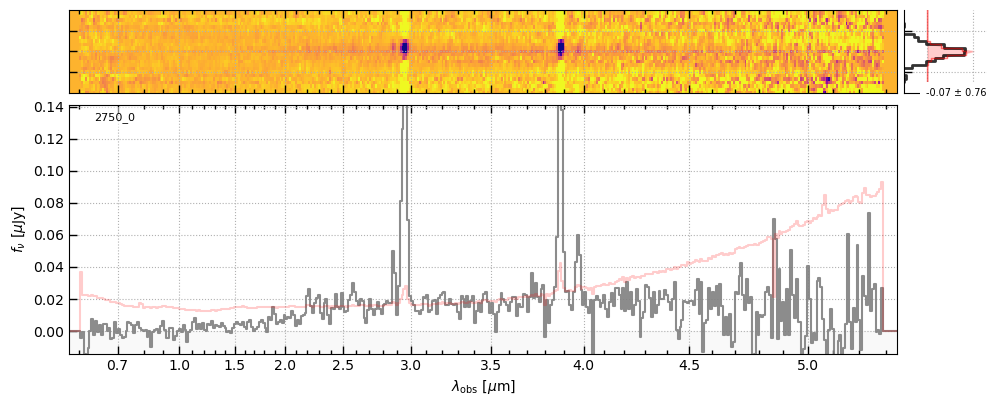

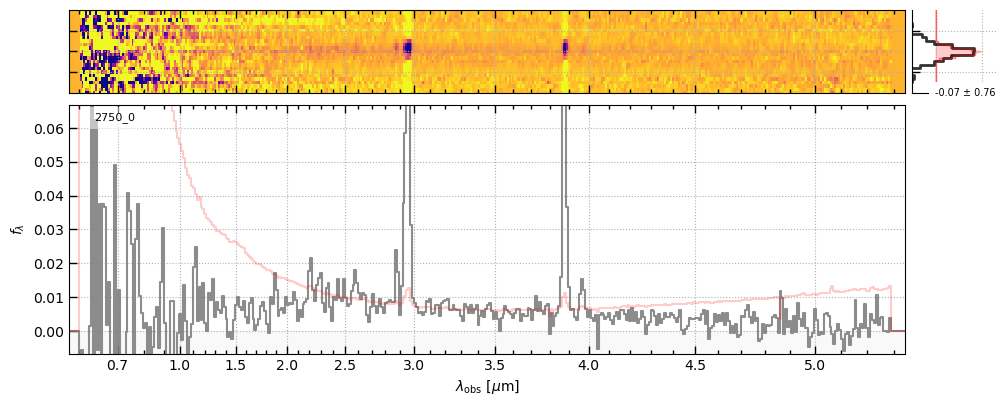

In [22]:
# Plot drizzled result

reload(msaexp.drizzle); reload(msaexp.utils)

hdul = hdu_data['prism-clear']

if target in ['2750_355']:
    kws = dict(prf_sigma=0.9, fix_sigma=False,
               prf_center=0.2, fix_center=False,
               verbose=True,
               sigma_bounds=(0.4, 2.5)
              )
elif target in ['2750_64']:
    kws = dict(prf_sigma=0.9, fix_sigma=False,
               prf_center=2, fix_center=True,
               verbose=True,
               sigma_bounds=(0.4, 2.5)
              )
elif target in ['2750_69']:
    kws = dict(prf_sigma=0.9, fix_sigma=False,
               prf_center=0.5, fix_center=True,
               verbose=True,
               sigma_bounds=(0.4, 2.5)
              )
else:
    kws = dict(prf_sigma=0.9, fix_sigma=False,
               prf_center=None, fix_center=False,
               verbose=True,
               sigma_bounds=(0.4, 2.5)
              )

outhdu = msaexp.drizzle.extract_from_hdul(hdul, **kws)

outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

# Make figures
fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


In [26]:
# Templates for redshift fitting

import eazy

try:
    _ = templ # already defined
except:
    if not os.path.exists('templates'):
        eazy.symlink_eazy_inputs()

    otempl = eazy.templates.read_templates_file('templates/sfhz/blue_sfhz_13.param')

    if 1:
        # smooth eazy templates
        dv = 250 # km/s
        wrest = utils.log_zgrid([300, 5.5e4], dv/3.e5)
        print(wrest.shape)
        templ = []
        for i, t in enumerate(otempl):
            print(i, t.name)
            templ.append(t.smooth_velocity(dv, in_place=False))
            templ[-1].resample(wrest, in_place=True)
    else:
        templ = otempl
    

1099it [00:02, 419.23it/s]
101it [00:00, 408.56it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_0.v1.spec.fits
# z = 4.90816
# Tue Mar 28 16:39:53 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_0.v1.spec.fits
# z = 4.90816
# Tue Mar 28 16:39:53 2023
             line Hb       31.2 ±      5.7
             line Hg       22.2 ±      7.4
             line Hd        5.1 ±      8.5
         line Ha+NII      160.7 ±      5.4
     line NeIII-3968        4.0 ±      9.1
           line OIII      314.9 ±      9.4
            line OII       35.3 ±     11.3
       line HeI-3889       22.1 ±      9.7
            line SII       23.5 ±      3.6
       line OII-7325        1.3 ±      3.4
     line ArIII-7138        3.9 ±      3.3
        line OI-6302       11.8 ±      4.2
       line HeI-5877        4.8 ±      3.5
      line OIII-1663      -29.5 ±     41.1
      line CIII-1908       52.7 ±     34.1
      line NIII-1750       12.1 ±     39.1
            line Lya      -70.8 ±     69.9
           line MgII        6.6 ±    

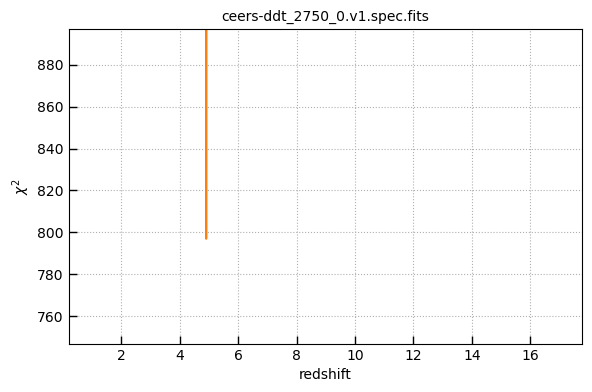

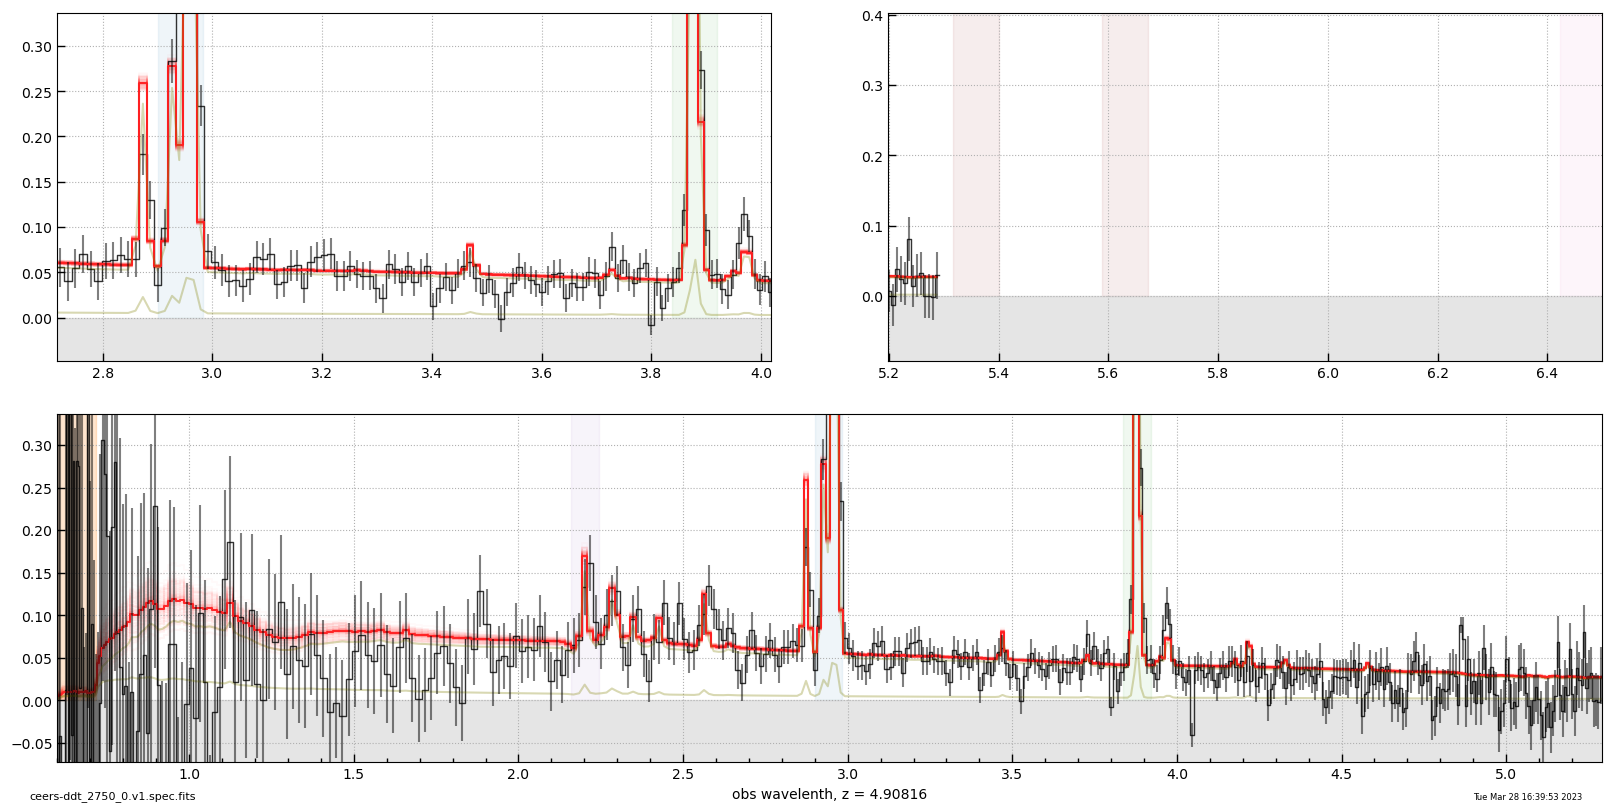

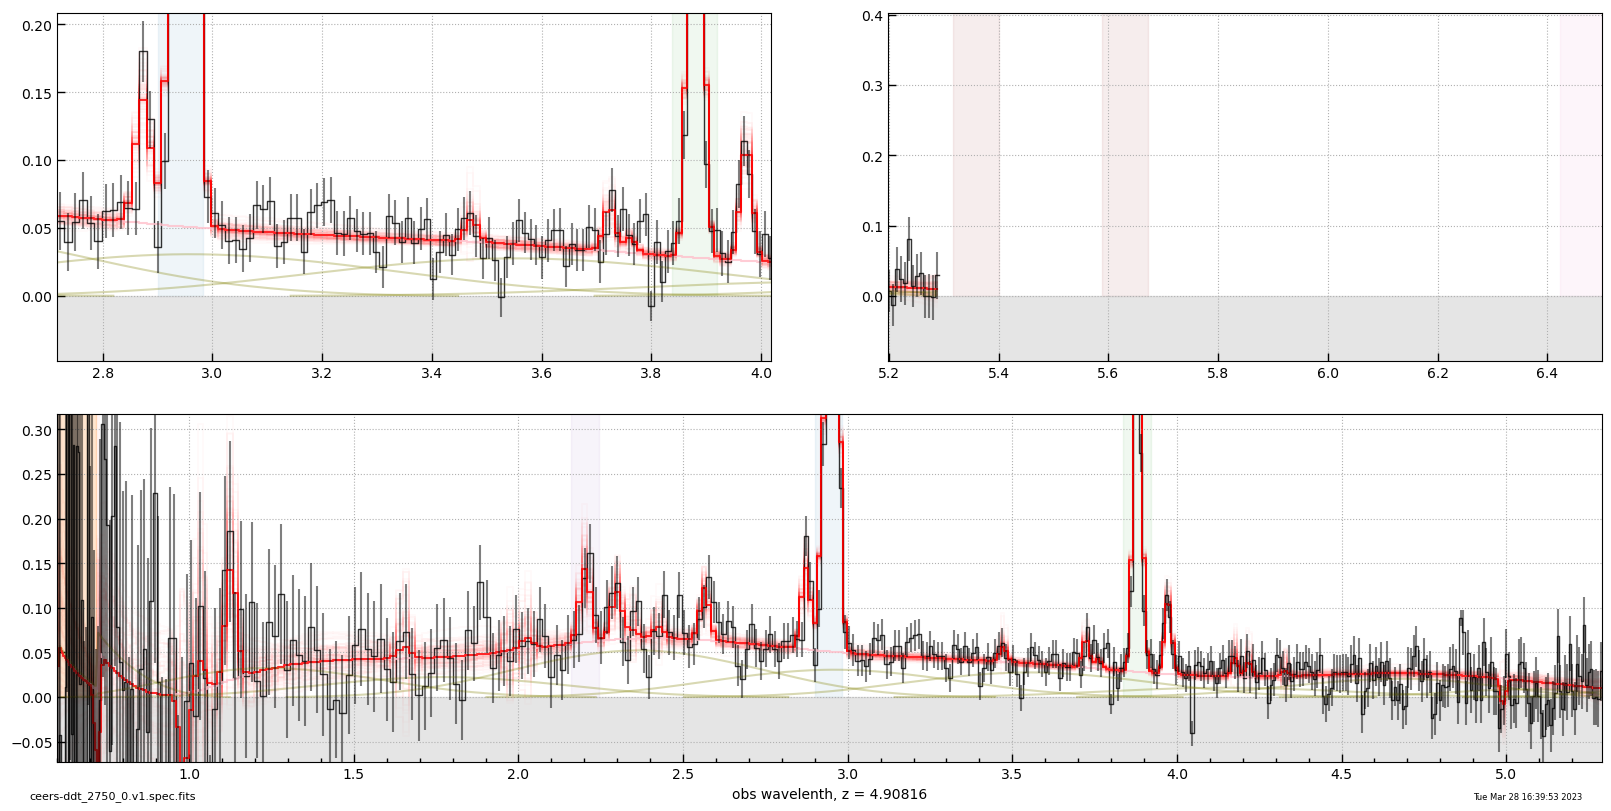

In [27]:
import msaexp.spectrum
import astropy.units as u
reload(msaexp.spectrum)

msaexp.spectrum.FFTSMOOTH = True

msaexp.spectrum.SCALE_UNCERTAINTY = 1./3

# file = f'{output_root}.spec.fits'

file = f'{outroot}_{target}.{file_version}.spec.fits'

zfit_kwargs = dict(z0=[1.0, 17],
                   eazy_templates=templ,
                   vel_width=50,
                   scale_disp=1.0,
                   nspline=11,
                   Rline=2000,
                   use_full_dispersion=False,
                   is_prism=True,
                   sys_err=0.02,
                   ranges=((4600, 6800), (8800, 1.1e4)),
                  )

plt_kwargs = dict(eazy_templates=None,
                  vel_width=50,
                  scale_disp=1.3,
                  nspline=11,
                  Rline=2000,
                  use_full_dispersion=True,
                  is_prism=True,
                  sys_err=0.02,
                  ranges=((4600, 6800), (8800, 1.1e4)),
                  scale_uncertainty_kwargs={'order':1},
                  plot_unit=u.microJansky,
                  )

zfit = msaexp.spectrum.fit_redshift(file=file, **zfit_kwargs)



Set SCALE_UNCERTAINTY:  [-0.02308138  0.19397561 -0.40008873 -0.41193306]

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_0.v1.spec.fits
# z = 4.90816
# Tue Mar 28 16:40:06 2023
             line Hb       29.2 ±      4.7
             line Hg       16.5 ±      5.4
             line Hd        2.6 ±      5.9
         line Ha+NII      159.4 ±      5.8
     line NeIII-3968        3.5 ±      6.3
           line OIII      305.3 ±      7.9
            line OII       29.5 ±      7.5
       line HeI-3889       19.2 ±      6.6
            line SII       20.5 ±      4.0
       line OII-7325        0.1 ±      3.8
     line ArIII-7138        2.9 ±      3.7
        line OI-6302        9.7 ±      4.4
       line HeI-5877        4.0 ±      3.5
      line OIII-1663      -23.9 ±     24.5
      line CIII-1908       45.5 ±     19.9
      line NIII-1750       16.4 ±     23.1
            line Lya      -71.9 ±     49.1
           line MgII        8.9 ±     12.4
       line NeV-3346       -0.3 ±   

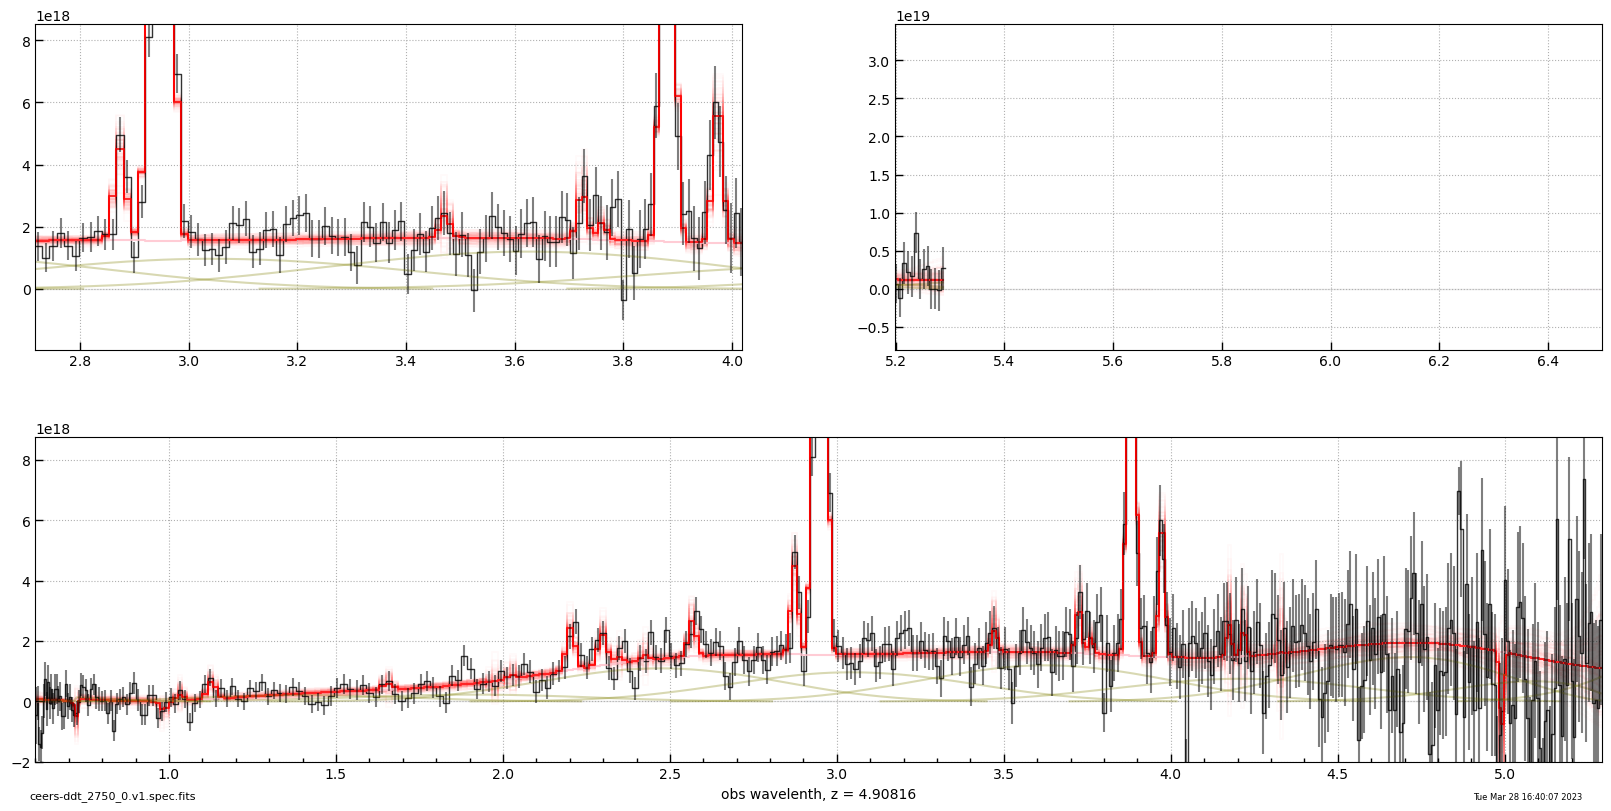

In [28]:
# Rescale uncertainties

plt_kwargs = dict(eazy_templates=None,
                  vel_width=200,
                  scale_disp=1.3,
                  nspline=11,
                  Rline=2000,
                  use_full_dispersion=True,
                  is_prism=True,
                  sys_err=0.02,
                  ranges=((4600, 6800), (8800, 1.1e4)),
                  scale_uncertainty_kwargs={'order':3},
                  plot_unit=u.microJansky,
                  )

best_z = zfit[1].meta['z']

msaexp.spectrum.SCALE_UNCERTAINTY = 1.

_ = msaexp.spectrum.plot_spectrum(file=file,
                                  z=best_z,
                                  **plt_kwargs,
                                  )

402it [00:00, 415.59it/s]
101it [00:00, 404.76it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_0.v1.spec.fits
# z = 4.90832
# Tue Mar 28 16:40:09 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_0.v1.spec.fits
# z = 4.90832
# Tue Mar 28 16:40:10 2023
             line Hb       31.6 ±      5.3
             line Hg       21.5 ±      6.2
             line Hd        4.0 ±      6.9
         line Ha+NII      161.8 ±      6.4
     line NeIII-3968        3.0 ±      7.2
           line OIII      315.3 ±      9.0
            line OII       34.6 ±      8.6
       line HeI-3889       21.3 ±      7.6
            line SII       23.7 ±      4.4
       line OII-7325        1.3 ±      4.3
     line ArIII-7138        4.2 ±      4.1
        line OI-6302       11.5 ±      4.9
       line HeI-5877        4.4 ±      3.9
      line OIII-1663      -28.0 ±     28.3
      line CIII-1908       52.9 ±     23.1
      line NIII-1750       13.2 ±     26.8
            line Lya      -72.3 ±     51.5
           line MgII        7.2 ±    

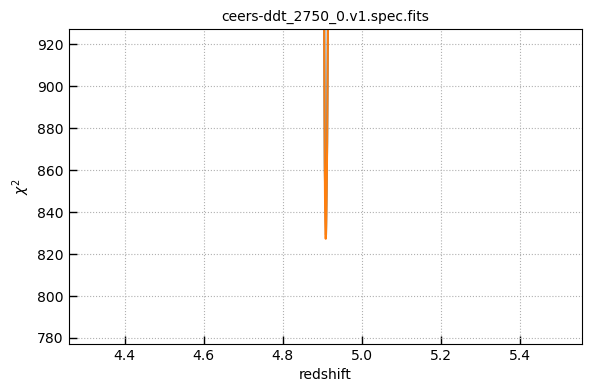

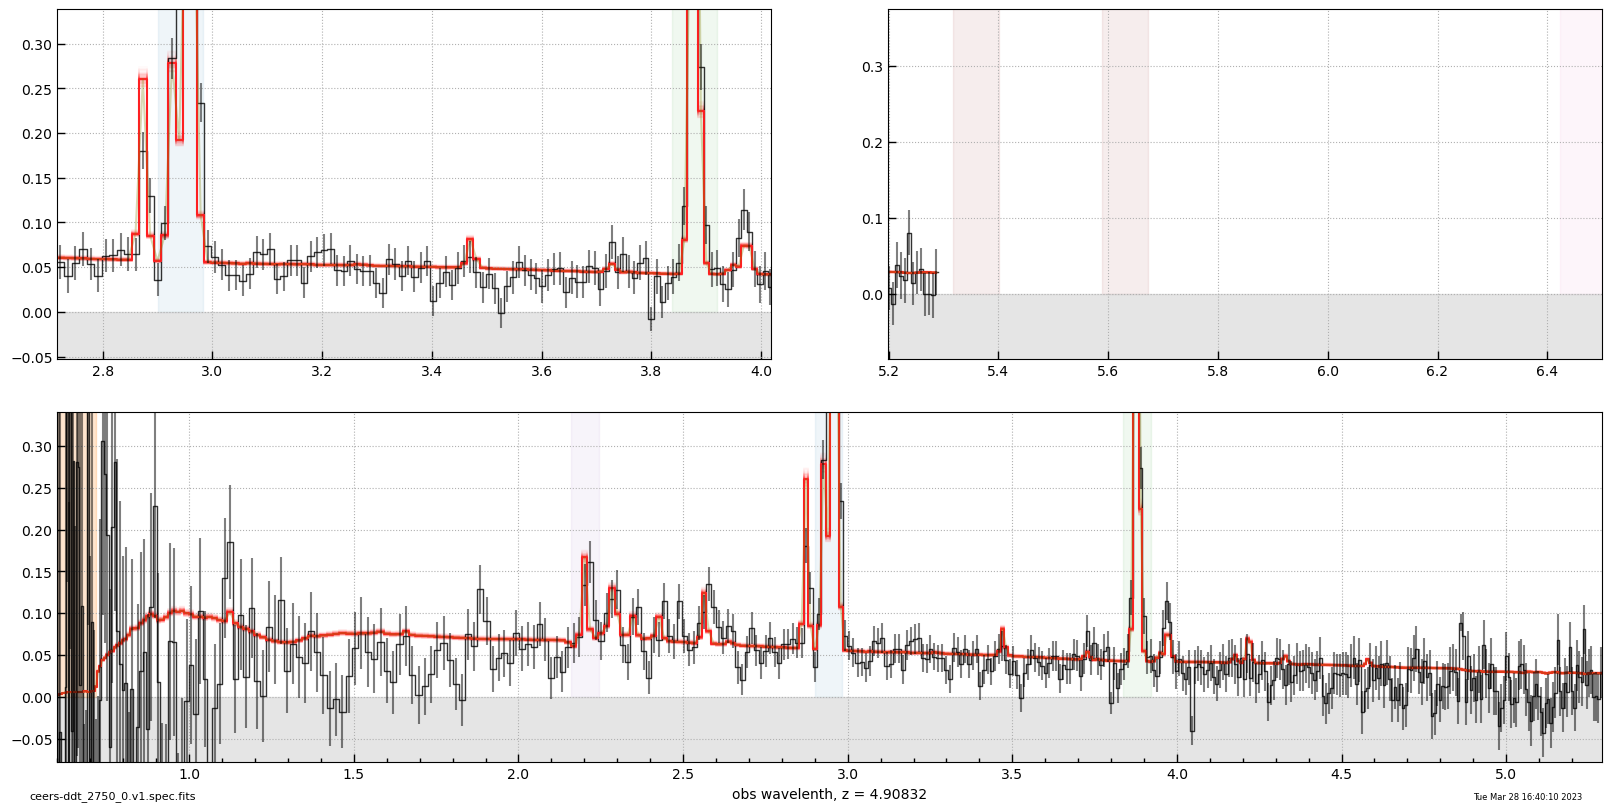

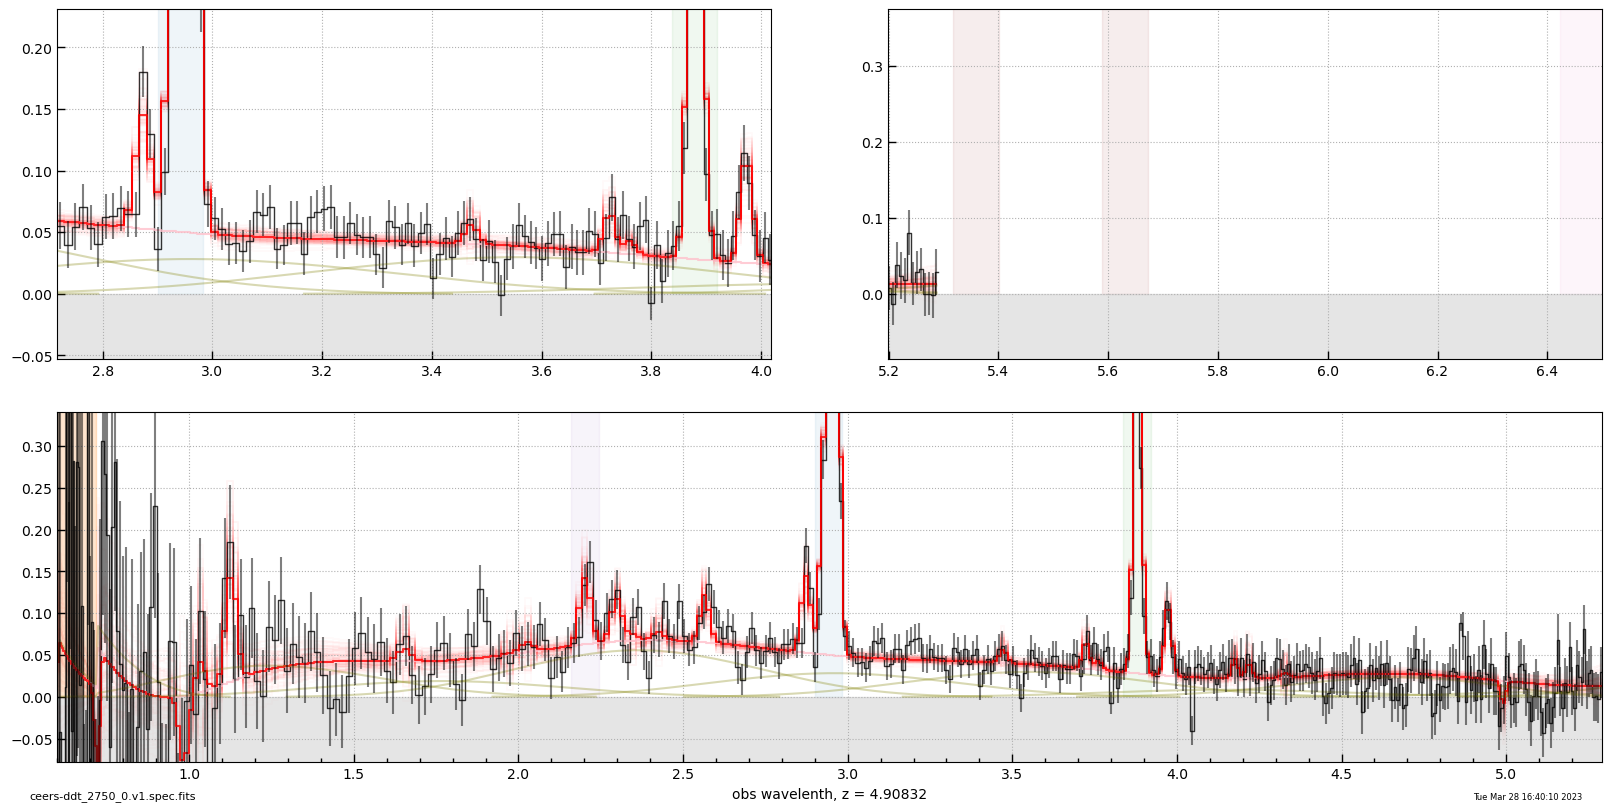

In [29]:
# Refit with just line templates

best_z = zfit[1].meta['z']

zfit_kwargs['z0'] = best_z + np.array([-0.1, 0.1])*(1+best_z)
zfit_kwargs['eazy_templates'] = templ

zfit = msaexp.spectrum.fit_redshift(file=file, zstep=(0.0005, 0.0001), **zfit_kwargs)

outhdu['SPEC1D'] = pyfits.BinTableHDU(zfit[1])

outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

best_z = zfit[1].meta['z']


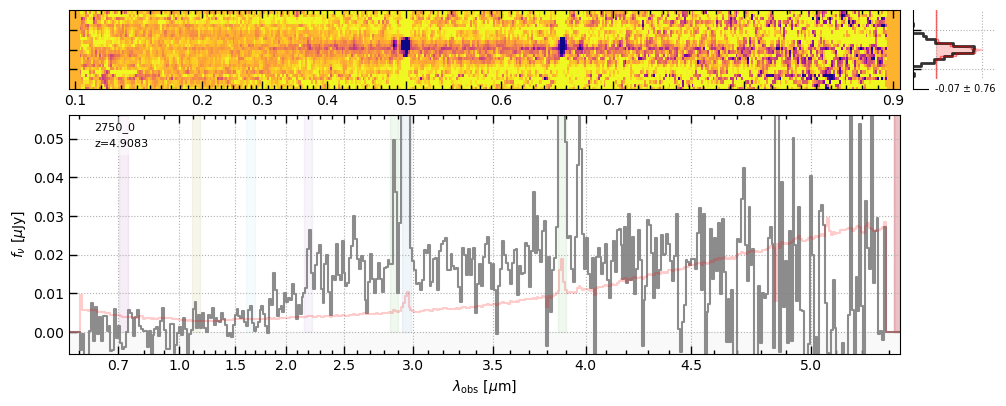

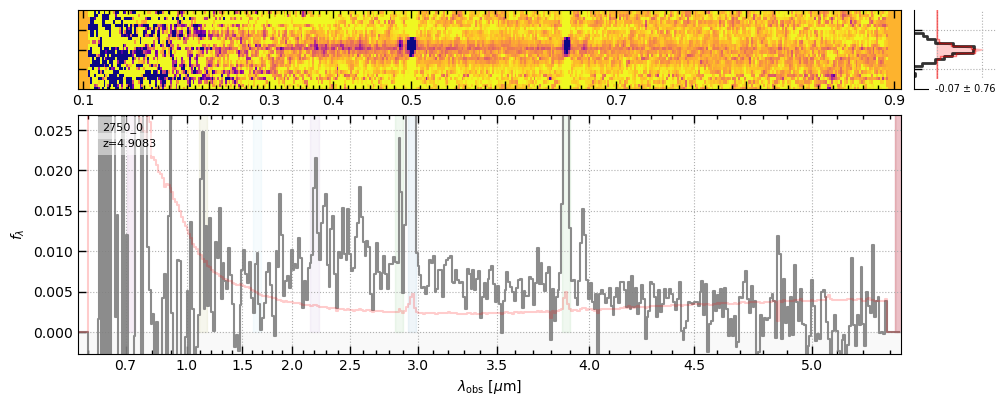

In [31]:
# Remake figures
reload(msaexp.utils)

fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu', z=best_z)
fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam', z=best_z)
fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


# Run on all sources

In [35]:
def run_everything(key, close=True):
    """
    """
    
    target = key
    
    slits = []

    for pipe in pipes:
        try:
            _ = pipe.extract_spectrum(key, skip=[], yoffset=0., prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)
        except IndexError:
            print(f'\n ! Error: {pipe.mode} {key} ! \n')
            plt.close()
            continue

        slits_i = pipe.get_background_slits(key, step='bkg', check_background=True)
        if slits_i is not None:
            print(pipe.mode, len(slits_i))
            slits.extend(slits_i)
    
    print(key, len(slits))
    
    if len(slits) == 0:
        print(f'No slitlets for object {key}')
        return False
    
    ####
    wave_sample = 1.05
    master_bkg = 0

    bkg_parity = []

    wave_arrays = {}

    if 0:
        # Use wavelength array from first slit
        wave_arrays = {}
        wave_arrays['prism-clear'] = msaexp.utils.get_slit_trace_wavelengths(slits[0])

    # flexible outlier threshold
    sn = slits[0].data / slits[0].err
    outlier_threshold = np.clip(np.nanpercentile(sn[slits[0].err > 0], 90)*2, 7, 100)
    # outlier_threshold = 1000

    print('outlier_threshold: ', outlier_threshold)

    if target == '2750_355':
        slits = slits[1:]

    try:
        _ = msaexp.drizzle.drizzle_slitlets(target,
                                        output=outroot,
                                        files=slits,
                                        center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                        fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                        force_nypix=31,         # Y size of output array
                                        bkg_offset=6,           # Number of pixels to roll for background subtraction
                                        bkg_parity=bkg_parity,  # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                        master_bkg=master_bkg,
                                        log_step=False,         # Log wavelength steps
                                        outlier_threshold=outlier_threshold,   # Outlier rejection threshold
                                        err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                        show_drizzled=True,     # Figures
                                        show_slits=True,
                                        imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                        sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                        bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                        drizzle_params=DRIZZLE_PARAMS,
                                        wave_sample=wave_sample,
                                        wave_arrays=wave_arrays,
                                        center_phase=-0.5,
                                       )
    except:
        print(f'{key} drizzle_slitlets failed')
        return False
    
    figs, hdu_data, wavedata, all_slits, drz_data = _
    
    ### Plot

    reload(msaexp.drizzle); reload(msaexp.utils)

    hdul = hdu_data['prism-clear']

    if target in ['2750_355']:
        kws = dict(prf_sigma=0.9, fix_sigma=False,
                   prf_center=0.2, fix_center=False,
                   verbose=True,
                   sigma_bounds=(0.4, 2.5)
                  )
    elif target in ['2750_64']:
        kws = dict(prf_sigma=0.9, fix_sigma=False,
                   prf_center=2, fix_center=True,
                   verbose=True,
                   sigma_bounds=(0.4, 2.5)
                  )
    elif target in ['2750_69']:
        kws = dict(prf_sigma=0.9, fix_sigma=False,
                   prf_center=0.5, fix_center=True,
                   verbose=True,
                   sigma_bounds=(0.4, 2.5)
                  )
    else:
        kws = dict(prf_sigma=0.9, fix_sigma=False,
                   prf_center=None, fix_center=False,
                   verbose=True,
                   sigma_bounds=(0.4, 2.5)
                  )

    try:
        outhdu = msaexp.drizzle.extract_from_hdul(hdul, **kws)
    except:
        print(f'{key} extract_from_hdul failed')

    outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

    # Make figures
    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
    fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
    fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')

    ### First pass redshift
    msaexp.spectrum.FFTSMOOTH = True

    msaexp.spectrum.SCALE_UNCERTAINTY = 1./3

    # file = f'{output_root}.spec.fits'

    file = f'{outroot}_{target}.{file_version}.spec.fits'

    zfit_kwargs = dict(z0=[1.0, 17],
                       eazy_templates=templ,
                       vel_width=50,
                       scale_disp=1.0,
                       nspline=11,
                       Rline=2000,
                       use_full_dispersion=False,
                       is_prism=True,
                       sys_err=0.02,
                       ranges=((4600, 6800), (8800, 1.1e4)),
                      )

    try:
        zfit = msaexp.spectrum.fit_redshift(file=file, **zfit_kwargs)
    except:
        print(f'{key} First pass fit_redshift failed')
    
    #### Rescale uncertainties
    plt_kwargs = dict(eazy_templates=None,
                  vel_width=200,
                  scale_disp=1.3,
                  nspline=11,
                  Rline=2000,
                  use_full_dispersion=True,
                  is_prism=True,
                  sys_err=0.02,
                  ranges=((4600, 6800), (8800, 1.1e4)),
                  scale_uncertainty_kwargs={'order':3},
                  plot_unit=u.microJansky,
                  )

    best_z = zfit[1].meta['z']

    msaexp.spectrum.SCALE_UNCERTAINTY = 1.

    _ = msaexp.spectrum.plot_spectrum(file=file,
                                      z=best_z,
                                      **plt_kwargs,
                                      )
    
    #### Refit with just line templates

    best_z = zfit[1].meta['z']

    zfit_kwargs['z0'] = best_z + np.array([-0.1, 0.1])*(1+best_z)
    zfit_kwargs['eazy_templates'] = templ

    zfit = msaexp.spectrum.fit_redshift(file=file, zstep=(0.0005, 0.0001), **zfit_kwargs)

    outhdu['SPEC1D'] = pyfits.BinTableHDU(zfit[1])

    outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

    best_z = zfit[1].meta['z']
    
    ### Remake figures
    reload(msaexp.utils)
    
    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam', z=best_z)
    fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')
    
    if close:
        # close all but last fnu figure
        plt.close('all')
        
    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu', z=best_z)
    fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

    
    return outhdu, zfit, fig
    

2023-03-28 16:43:19,794 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



jw02750002001-01-03-clear-prism-nrs1 3
2750_0 not found in slitlets
jw02750002001-01-05-clear-prism-nrs1 3
2750_0 not found in slitlets
jw02750002001-01-07-clear-prism-nrs1 3
2750_0 not found in slitlets
2750_0 9
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2750_0 read 9 files
msaexp.drizzle.drizzle_slitlets: id=2750_0  prism-clear N=9
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2750_0
msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2750_0                     0 -0.011 <SlitModel(20, 435) from jw02750002001_03101_00001_nrs1_phot.209.2750_0.fits> (20, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2750_0                     0  0.005 <SlitModel(20, 435) from jw02750002001_03101_00002_nrs1_phot.209.2750_0.fits> (20, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2750_0                     0 -0.027 <SlitModel(20, 435) from jw02750002001_03101_00003_nrs1_phot.209.2750_0.fits> (20, 435)
msaexp.drizzle

1099it [00:02, 409.83it/s]
101it [00:00, 409.86it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_0.v1.spec.fits
# z = 4.90816
# Tue Mar 28 16:43:36 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_0.v1.spec.fits
# z = 4.90816
# Tue Mar 28 16:43:36 2023
             line Hb       30.6 ±      5.7
             line Hg       22.1 ±      7.3
             line Hd        5.0 ±      8.4
         line Ha+NII      159.6 ±      5.4
     line NeIII-3968        4.0 ±      9.0
           line OIII      310.6 ±      9.3
            line OII       34.8 ±     11.2
       line HeI-3889       21.7 ±      9.6
            line SII       23.5 ±      3.6
       line OII-7325        1.4 ±      3.4
     line ArIII-7138        3.9 ±      3.3
        line OI-6302       10.2 ±      4.1
       line HeI-5877        4.7 ±      3.5
      line OIII-1663      -28.9 ±     40.7
      line CIII-1908       52.2 ±     33.8
      line NIII-1750       12.1 ±     38.7
            line Lya      -69.7 ±     69.3
           line MgII        6.2 ±    

2023-03-28 16:43:37,288 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:43:37,289 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:43:37,289 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



Set SCALE_UNCERTAINTY:  [-0.02265247  0.18996599 -0.38972877 -0.41843557]

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_0.v1.spec.fits
# z = 4.90816
# Tue Mar 28 16:43:38 2023
             line Hb       28.6 ±      4.7
             line Hg       16.4 ±      5.4
             line Hd        2.6 ±      5.9
         line Ha+NII      158.4 ±      5.8
     line NeIII-3968        3.5 ±      6.3
           line OIII      301.3 ±      7.9
            line OII       29.1 ±      7.4
       line HeI-3889       18.9 ±      6.6
            line SII       20.5 ±      4.0
       line OII-7325        0.2 ±      3.8
     line ArIII-7138        2.8 ±      3.6
        line OI-6302        8.6 ±      4.3
       line HeI-5877        4.0 ±      3.4
      line OIII-1663      -23.4 ±     24.2
      line CIII-1908       44.9 ±     19.7
      line NIII-1750       16.2 ±     22.9
            line Lya      -70.8 ±     48.6
           line MgII        8.5 ±     12.3
       line NeV-3346       -0.3 ±   

402it [00:00, 410.84it/s]
101it [00:00, 412.24it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_0.v1.spec.fits
# z = 4.90832
# Tue Mar 28 16:43:39 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_0.v1.spec.fits
# z = 4.90832
# Tue Mar 28 16:43:39 2023
             line Hb       31.0 ±      5.3
             line Hg       21.4 ±      6.2
             line Hd        4.0 ±      6.9
         line Ha+NII      160.6 ±      6.4
     line NeIII-3968        3.0 ±      7.2
           line OIII      310.9 ±      9.0
            line OII       34.1 ±      8.5
       line HeI-3889       21.0 ±      7.6
            line SII       23.7 ±      4.4
       line OII-7325        1.4 ±      4.2
     line ArIII-7138        4.1 ±      4.1
        line OI-6302        9.9 ±      4.9
       line HeI-5877        4.4 ±      3.9
      line OIII-1663      -27.4 ±     28.0
      line CIII-1908       52.3 ±     22.9
      line NIII-1750       13.1 ±     26.5
            line Lya      -71.2 ±     50.9
           line MgII        6.8 ±    

2023-03-28 16:43:40,160 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:43:40,160 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:43:40,160 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



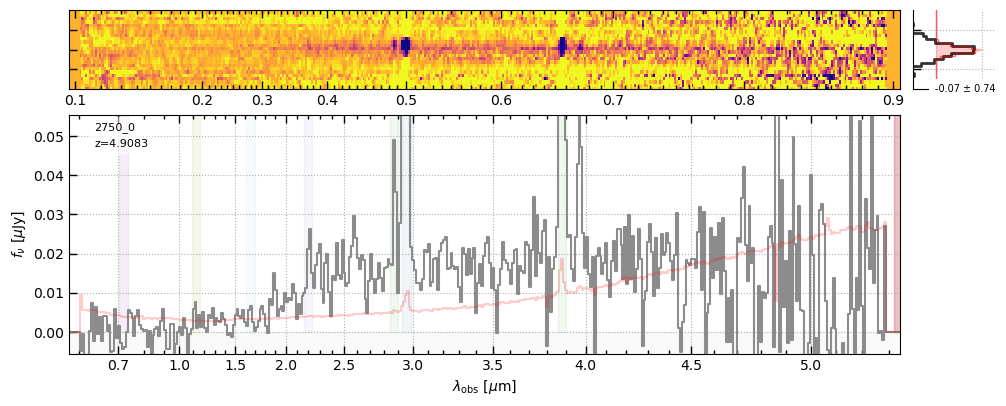

In [37]:
outhdu, zfit, fig = run_everything(targets[0])

In [38]:
for key in targets[1:]:
    outhdu, zfit, fig = run_everything(key)
    
plt.close('all')

2023-03-28 16:43:42,041 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



jw02750002001-01-03-clear-prism-nrs1 3
2750_1 not found in slitlets
jw02750002001-01-05-clear-prism-nrs1 3
2750_1 not found in slitlets
jw02750002001-01-07-clear-prism-nrs1 3
2750_1 not found in slitlets
2750_1 9
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2750_1 read 9 files
msaexp.drizzle.drizzle_slitlets: id=2750_1  prism-clear N=9
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2750_1
msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2750_1                     1 -0.155 <SlitModel(22, 439) from jw02750002001_03101_00001_nrs1_phot.290.2750_1.fits> (22, 439)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2750_1                     1 -0.141 <SlitModel(22, 439) from jw02750002001_03101_00002_nrs1_phot.290.2750_1.fits> (22, 439)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2750_1                     1 -0.169 <SlitModel(22, 439) from jw02750002001_03101_00003_nrs1_phot.290.2750_1.fits> (22, 439)
msaexp.drizzle

1099it [00:02, 432.11it/s]
101it [00:00, 414.56it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_1.v1.spec.fits
# z = 11.41040
# Tue Mar 28 16:43:58 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_1.v1.spec.fits
# z = 11.41040
# Tue Mar 28 16:43:58 2023
             line Hd       -3.5 ±      4.2
     line NeIII-3968       -2.5 ±      3.9
            line OII       18.2 ±      3.7
     line NeIII-3867       10.2 ±      3.8
       line HeI-3889        8.0 ±      3.8
      line OIII-1663       22.2 ±     12.8
      line CIII-1908       20.6 ±      9.0
      line NIII-1750       12.4 ±     11.1
            line Lya      -69.7 ±     54.2
           line MgII       -1.7 ±      3.3
       line NeV-3346       -1.8 ±      3.0
      line NeVI-3426        1.1 ±      3.1


2023-03-28 16:43:58,452 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:43:58,453 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:43:58,453 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



Set SCALE_UNCERTAINTY:  [-0.02308337  0.20873085 -0.5380748  -0.19120286]

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_1.v1.spec.fits
# z = 11.41040
# Tue Mar 28 16:43:58 2023
             line Hd       -3.5 ±      3.1
     line NeIII-3968       -2.1 ±      3.0
            line OII       16.6 ±      3.1
     line NeIII-3867       10.4 ±      3.1
       line HeI-3889        8.5 ±      3.1
      line OIII-1663       16.6 ±      8.0
      line CIII-1908       16.0 ±      6.0
      line NIII-1750       10.3 ±      7.1
            line Lya      -63.0 ±     36.5
           line MgII       -1.6 ±      2.7
       line NeV-3346       -1.3 ±      2.6
      line NeVI-3426        1.3 ±      2.7


402it [00:00, 410.57it/s]
101it [00:00, 406.93it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_1.v1.spec.fits
# z = 11.41073
# Tue Mar 28 16:44:00 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_1.v1.spec.fits
# z = 11.41073
# Tue Mar 28 16:44:00 2023
             line Hd       -3.6 ±      3.4
     line NeIII-3968       -2.6 ±      3.4
            line OII       18.4 ±      3.5
     line NeIII-3867       10.2 ±      3.5
       line HeI-3889        7.9 ±      3.4
      line OIII-1663       21.9 ±      9.3
      line CIII-1908       20.9 ±      6.8
      line NIII-1750       12.4 ±      8.1
            line Lya      -68.4 ±     41.2
           line MgII       -1.6 ±      3.0
       line NeV-3346       -1.9 ±      2.9
      line NeVI-3426        1.0 ±      3.0


2023-03-28 16:44:00,789 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:00,790 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:00,790 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:02,347 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-pac

jw02750002001-01-03-clear-prism-nrs1 3
2750_2 not found in slitlets
jw02750002001-01-05-clear-prism-nrs1 3
2750_2 not found in slitlets
jw02750002001-01-07-clear-prism-nrs1 3
2750_2 not found in slitlets
2750_2 9
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2750_2 read 9 files
msaexp.drizzle.drizzle_slitlets: id=2750_2  prism-clear N=9
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2750_2
msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2750_2                     2 -0.326 <SlitModel(20, 432) from jw02750002001_03101_00001_nrs1_phot.179.2750_2.fits> (20, 432)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2750_2                     2 -0.314 <SlitModel(20, 432) from jw02750002001_03101_00002_nrs1_phot.179.2750_2.fits> (20, 432)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2750_2                     2 -0.339 <SlitModel(20, 432) from jw02750002001_03101_00003_nrs1_phot.179.2750_2.fits> (20, 432)
msaexp.drizzle

1099it [00:02, 404.10it/s]
101it [00:00, 393.83it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_2.v1.spec.fits
# z = 4.90639
# Tue Mar 28 16:44:18 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_2.v1.spec.fits
# z = 4.90639
# Tue Mar 28 16:44:18 2023
             line Hb      -16.8 ±     11.2
             line Hg       15.2 ±     15.5
             line Hd        7.3 ±     18.3
         line Ha+NII      145.5 ±      9.1
     line NeIII-3968       10.4 ±     19.4
           line OIII       19.2 ±     12.7
            line OII      -14.5 ±     23.5
       line HeI-3889       28.6 ±     20.5
            line SII       15.7 ±      7.5
       line OII-7325        2.5 ±      7.3
     line ArIII-7138       14.2 ±      7.1
        line OI-6302       16.0 ±      9.3
       line HeI-5877      -16.3 ±      7.5
      line OIII-1663      -16.9 ±     92.1
      line CIII-1908        9.7 ±     75.9
      line NIII-1750       54.4 ±     87.4
            line Lya      -23.7 ±    157.0
           line MgII        4.8 ±    

2023-03-28 16:44:19,047 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:19,047 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:19,047 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



Set SCALE_UNCERTAINTY:  [-0.0199594   0.17299921 -0.40898358 -0.32677662]

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_2.v1.spec.fits
# z = 4.90639
# Tue Mar 28 16:44:19 2023
             line Hb      -11.8 ±      8.4
             line Hg       13.2 ±     10.7
             line Hd        4.2 ±     12.4
         line Ha+NII      131.9 ±      8.2
     line NeIII-3968        8.4 ±     13.0
           line OIII       20.4 ±     10.1
            line OII      -12.0 ±     15.3
       line HeI-3889       25.4 ±     13.7
            line SII       12.9 ±      6.9
       line OII-7325        1.7 ±      6.6
     line ArIII-7138       12.2 ±      6.3
        line OI-6302       16.7 ±      8.2
       line HeI-5877      -15.5 ±      6.3
      line OIII-1663       -1.6 ±     62.8
      line CIII-1908       -6.6 ±     49.9
      line NIII-1750       35.7 ±     58.7
            line Lya      -12.8 ±    131.0
           line MgII        6.0 ±     29.7
       line NeV-3346      -11.4 ±   

402it [00:01, 398.35it/s]
101it [00:00, 392.85it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_2.v1.spec.fits
# z = 4.90655
# Tue Mar 28 16:44:21 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_2.v1.spec.fits
# z = 4.90655
# Tue Mar 28 16:44:21 2023
             line Hb      -16.2 ±      9.6
             line Hg       14.5 ±     12.4
             line Hd        6.0 ±     14.3
         line Ha+NII      145.1 ±      9.2
     line NeIII-3968        9.2 ±     15.0
           line OIII       20.2 ±     11.0
            line OII      -15.5 ±     17.7
       line HeI-3889       27.5 ±     15.7
            line SII       15.7 ±      7.6
       line OII-7325        2.7 ±      7.4
     line ArIII-7138       14.5 ±      7.2
        line OI-6302       15.4 ±      9.1
       line HeI-5877      -16.7 ±      7.2
      line OIII-1663      -19.6 ±     72.6
      line CIII-1908        6.8 ±     58.0
      line NIII-1750       51.5 ±     68.3
            line Lya      -19.1 ±    135.4
           line MgII        6.3 ±    

2023-03-28 16:44:22,044 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:22,044 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:22,044 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:22,877 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-pac

jw02750002001-01-03-clear-prism-nrs1 3
2750_2763 not found in slitlets
jw02750002001-01-05-clear-prism-nrs1 3
2750_2763 not found in slitlets
jw02750002001-01-07-clear-prism-nrs1 3
2750_2763 not found in slitlets
2750_2763 9
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2750_2763 read 9 files
msaexp.drizzle.drizzle_slitlets: id=2750_2763  prism-clear N=9
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2750_2763
msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2750_2763               2763  0.015 <SlitModel(20, 434) from jw02750002001_03101_00001_nrs1_phot.247.2750_2763.fits> (20, 434)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2750_2763               2763  0.025 <SlitModel(20, 434) from jw02750002001_03101_00002_nrs1_phot.247.2750_2763.fits> (20, 434)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2750_2763               2763  0.004 <SlitModel(20, 434) from jw02750002001_03101_00003_nrs1_phot.247.2750_2763.

2023-03-28 16:44:36,026 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/card.py:1064: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn(



msaexp.drizzle.extract_from_hdul: Initial center =  -1.07, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =   1.41, sigma =   1.24


1099it [00:02, 426.48it/s]
101it [00:00, 404.25it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_2763.v1.spec.fits
# z = 4.90285
# Tue Mar 28 16:44:39 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_2763.v1.spec.fits
# z = 4.90285
# Tue Mar 28 16:44:40 2023
             line Hb       99.9 ±      9.5
             line Hg       41.7 ±     11.9
             line Hd       25.5 ±     13.7
         line Ha+NII      308.6 ±      9.0
     line NeIII-3968       19.2 ±     14.5
           line OIII      801.2 ±     17.3
            line OII      206.6 ±     19.0
       line HeI-3889       65.0 ±     15.6
            line SII       32.7 ±      5.0
       line OII-7325       13.3 ±      4.5
     line ArIII-7138       -0.9 ±      4.4
        line OI-6302       11.0 ±      6.2
       line HeI-5877       22.0 ±      5.4
      line OIII-1663       85.9 ±     61.1
      line CIII-1908       59.6 ±     52.3
      line NIII-1750      -30.2 ±     57.4
            line Lya     -315.4 ±     97.8
           line MgII      -39.2

2023-03-28 16:44:40,487 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:40,487 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:40,488 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



Set SCALE_UNCERTAINTY:  [-0.03391629  0.27153609 -0.58279697 -0.22864404]

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_2763.v1.spec.fits
# z = 4.90285
# Tue Mar 28 16:44:41 2023
             line Hb       90.1 ±      8.2
             line Hg       34.7 ±      9.2
             line Hd       17.7 ±     10.2
         line Ha+NII      311.0 ±      9.5
     line NeIII-3968       18.7 ±     10.6
           line OIII      799.0 ±     14.4
            line OII      193.2 ±     13.1
       line HeI-3889       54.3 ±     11.2
            line SII       28.4 ±      5.5
       line OII-7325       10.7 ±      4.7
     line ArIII-7138       -1.3 ±      4.6
        line OI-6302        9.4 ±      6.7
       line HeI-5877       19.3 ±      5.6
      line OIII-1663       74.0 ±     41.4
      line CIII-1908       64.3 ±     33.6
      line NIII-1750      -24.5 ±     38.2
            line Lya     -308.4 ±     86.6
           line MgII      -30.7 ±     20.4
       line NeV-3346      -20.2 ±

402it [00:00, 417.05it/s]
101it [00:00, 415.06it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_2763.v1.spec.fits
# z = 4.90301
# Tue Mar 28 16:44:42 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_2763.v1.spec.fits
# z = 4.90301
# Tue Mar 28 16:44:42 2023
             line Hb      100.2 ±      9.8
             line Hg       41.3 ±     11.1
             line Hd       25.0 ±     12.4
         line Ha+NII      311.4 ±     10.7
     line NeIII-3968       18.6 ±     12.8
           line OIII      803.3 ±     17.9
            line OII      205.5 ±     16.3
       line HeI-3889       64.7 ±     13.6
            line SII       32.4 ±      6.1
       line OII-7325       13.4 ±      5.2
     line ArIII-7138       -0.9 ±      5.2
        line OI-6302       10.7 ±      7.6
       line HeI-5877       22.0 ±      6.5
      line OIII-1663       94.0 ±     50.4
      line CIII-1908       65.2 ±     42.1
      line NIII-1750      -22.2 ±     46.8
            line Lya     -324.8 ±     88.3
           line MgII      -40.2

2023-03-28 16:44:43,293 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:43,293 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:43,293 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:44:44,137 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-pac

jw02750002001-01-03-clear-prism-nrs1 3
2750_28 not found in slitlets
jw02750002001-01-05-clear-prism-nrs1 3
2750_28 not found in slitlets
jw02750002001-01-07-clear-prism-nrs1 3
2750_28 not found in slitlets
2750_28 9
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2750_28 read 9 files
msaexp.drizzle.drizzle_slitlets: id=2750_28  prism-clear N=9
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2750_28
msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2750_28                   28  0.270 <SlitModel(20, 429) from jw02750002001_03101_00001_nrs1_phot.255.2750_28.fits> (20, 429)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2750_28                   28  0.266 <SlitModel(20, 429) from jw02750002001_03101_00002_nrs1_phot.255.2750_28.fits> (20, 429)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2750_28                   28  0.274 <SlitModel(20, 429) from jw02750002001_03101_00003_nrs1_phot.255.2750_28.fits> (20, 429)
msae

1099it [00:02, 418.49it/s]
101it [00:00, 384.74it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_28.v1.spec.fits
# z = 8.76236
# Tue Mar 28 16:45:00 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_28.v1.spec.fits
# z = 8.76236
# Tue Mar 28 16:45:00 2023
             line Hb       66.1 ±      5.1
             line Hg       39.4 ±      4.6
             line Hd       23.9 ±      4.0
     line NeIII-3968       12.5 ±      3.9
      line OIII-4959      127.6 ±      5.7
      line OIII-5007      351.8 ±      8.2
      line OIII-4363        4.5 ±      4.0
            line OII       46.6 ±      4.6
      line HeII-4687        6.0 ±      4.1
     line NeIII-3867       43.0 ±      4.6
       line HeI-3889       -2.2 ±      4.2
      line OIII-1663      -26.8 ±     30.5
      line CIII-1908       66.5 ±     22.2
      line NIII-1750      -27.7 ±     26.4
            line Lya     -381.6 ±     55.6
           line MgII       -6.4 ±      7.3
       line NeV-3346        3.9 ±      4.7
      line NeVI-3426        4.8 ±  

2023-03-28 16:45:00,913 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:00,914 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:00,914 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



Set SCALE_UNCERTAINTY:  [-0.0136478   0.12687713 -0.32490283 -0.34083315]

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_28.v1.spec.fits
# z = 8.76236
# Tue Mar 28 16:45:01 2023
             line Hb       59.6 ±      4.4
             line Hg       35.3 ±      4.0
             line Hd       20.6 ±      3.5
     line NeIII-3968       11.1 ±      3.3
      line OIII-4959      116.3 ±      4.9
      line OIII-5007      336.2 ±      6.5
      line OIII-4363        6.3 ±      3.4
            line OII       42.5 ±      3.9
      line HeII-4687        4.2 ±      3.6
     line NeIII-3867       38.4 ±      3.7
       line HeI-3889       -0.3 ±      3.3
      line OIII-1663      -27.6 ±     19.9
      line CIII-1908       61.4 ±     14.5
      line NIII-1750      -20.6 ±     17.2
            line Lya     -294.9 ±     35.4
           line MgII       -6.2 ±      5.3
       line NeV-3346        2.3 ±      3.7
      line NeVI-3426        3.1 ±      3.6


402it [00:01, 391.89it/s]
101it [00:00, 389.57it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_28.v1.spec.fits
# z = 8.76165
# Tue Mar 28 16:45:04 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_28.v1.spec.fits
# z = 8.76165
# Tue Mar 28 16:45:04 2023
             line Hb       66.1 ±      5.0
             line Hg       39.6 ±      4.6
             line Hd       24.0 ±      4.0
     line NeIII-3968       12.2 ±      3.8
      line OIII-4959      127.0 ±      5.6
      line OIII-5007      350.2 ±      8.0
      line OIII-4363        4.9 ±      4.0
            line OII       46.3 ±      4.4
      line HeII-4687        5.8 ±      4.1
     line NeIII-3867       42.6 ±      4.4
       line HeI-3889       -1.9 ±      4.0
      line OIII-1663      -26.1 ±     23.7
      line CIII-1908       67.2 ±     17.3
      line NIII-1750      -26.9 ±     20.5
            line Lya     -382.0 ±     44.8
           line MgII       -6.4 ±      6.1
       line NeV-3346        4.0 ±      4.3
      line NeVI-3426        4.7 ±  

2023-03-28 16:45:04,684 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:04,684 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:04,684 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:05,474 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-pac

jw02750002001-01-03-clear-prism-nrs1 3
2750_3149 not found in slitlets
jw02750002001-01-05-clear-prism-nrs1 3
2750_3149 not found in slitlets
jw02750002001-01-07-clear-prism-nrs1 3
2750_3149 not found in slitlets
2750_3149 9
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2750_3149 read 9 files
msaexp.drizzle.drizzle_slitlets: id=2750_3149  prism-clear N=9
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2750_3149
msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2750_3149               3149  0.221 <SlitModel(20, 434) from jw02750002001_03101_00001_nrs1_phot.215.2750_3149.fits> (20, 434)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2750_3149               3149  0.237 <SlitModel(20, 434) from jw02750002001_03101_00002_nrs1_phot.215.2750_3149.fits> (20, 434)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2750_3149               3149  0.205 <SlitModel(20, 434) from jw02750002001_03101_00003_nrs1_phot.215.2750_3149.

2023-03-28 16:45:17,853 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/card.py:1064: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn(



msaexp.drizzle.extract_from_hdul: Initial center =  -2.06, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =  -0.24, sigma =   1.13


1099it [00:02, 424.38it/s]
101it [00:00, 401.62it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_3149.v1.spec.fits
# z = 4.90049
# Tue Mar 28 16:45:21 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_3149.v1.spec.fits
# z = 4.90049
# Tue Mar 28 16:45:21 2023
             line Hb      191.3 ±     10.8
             line Hg       86.4 ±     11.7
             line Hd       65.7 ±     13.3
         line Ha+NII      479.1 ±     10.3
     line NeIII-3968       36.5 ±     13.9
           line OIII     1262.3 ±     21.7
            line OII      299.1 ±     19.0
       line HeI-3889       95.6 ±     15.2
            line SII       62.0 ±      5.1
       line OII-7325       17.3 ±      4.5
     line ArIII-7138        9.1 ±      4.3
        line OI-6302       16.3 ±      5.9
       line HeI-5877       22.3 ±      5.3
      line OIII-1663      -47.1 ±     56.6
      line CIII-1908       12.2 ±     47.6
      line NIII-1750     -101.2 ±     53.5
            line Lya     -184.0 ±     97.1
           line MgII      -60.8

2023-03-28 16:45:22,352 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:22,352 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:22,352 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



Set SCALE_UNCERTAINTY:  [-0.0327742   0.26418609 -0.5657977  -0.25130553]

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_3149.v1.spec.fits
# z = 4.90049
# Tue Mar 28 16:45:22 2023
             line Hb      168.5 ±      8.9
             line Hg       74.4 ±      8.8
             line Hd       51.7 ±      9.7
         line Ha+NII      508.6 ±     10.2
     line NeIII-3968       32.9 ±     10.0
           line OIII     1257.7 ±     16.7
            line OII      266.8 ±     12.6
       line HeI-3889       81.8 ±     10.7
            line SII       53.8 ±      5.6
       line OII-7325       15.0 ±      4.7
     line ArIII-7138        6.7 ±      4.6
        line OI-6302       13.2 ±      6.4
       line HeI-5877       18.6 ±      5.5
      line OIII-1663      -21.3 ±     37.8
      line CIII-1908       23.9 ±     30.0
      line NIII-1750      -70.6 ±     35.0
            line Lya     -225.2 ±     85.1
           line MgII      -61.1 ±     18.3
       line NeV-3346       -8.6 ±

402it [00:00, 420.37it/s]
101it [00:00, 408.81it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_3149.v1.spec.fits
# z = 4.90064
# Tue Mar 28 16:45:24 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_3149.v1.spec.fits
# z = 4.90064
# Tue Mar 28 16:45:24 2023
             line Hb      191.1 ±     10.9
             line Hg       86.9 ±     10.8
             line Hd       66.6 ±     11.8
         line Ha+NII      488.0 ±     12.0
     line NeIII-3968       37.1 ±     12.1
           line OIII     1263.4 ±     22.1
            line OII      299.3 ±     16.2
       line HeI-3889       96.5 ±     13.1
            line SII       61.7 ±      6.3
       line OII-7325       17.3 ±      5.3
     line ArIII-7138        8.8 ±      5.2
        line OI-6302       16.3 ±      7.2
       line HeI-5877       22.5 ±      6.3
      line OIII-1663      -35.1 ±     45.1
      line CIII-1908       21.6 ±     37.1
      line NIII-1750      -88.8 ±     42.3
            line Lya     -200.0 ±     84.7
           line MgII      -63.6

2023-03-28 16:45:25,002 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:25,002 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:25,003 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:25,858 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-pac

jw02750002001-01-03-clear-prism-nrs1 3
2750_355 not found in slitlets
jw02750002001-01-05-clear-prism-nrs1 3
2750_355 not found in slitlets
jw02750002001-01-07-clear-prism-nrs1 3
2750_355 not found in slitlets
2750_355 9
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2750_355 read 8 files
msaexp.drizzle.drizzle_slitlets: id=2750_355  prism-clear N=8
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2750_355
msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2750_355                 355  0.052 <SlitModel(22, 436) from jw02750002001_03101_00002_nrs1_phot.288.2750_355.fits> (22, 436)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2750_355                 355  0.037 <SlitModel(22, 436) from jw02750002001_03101_00003_nrs1_phot.288.2750_355.fits> (22, 436)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2750_355                 355  0.044 <SlitModel(22, 436) from jw02750002001_05101_00001_nrs1_phot.288.2750_355.fits> (22,

2023-03-28 16:45:37,584 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/card.py:1064: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn(



msaexp.drizzle.extract_from_hdul: Initial center =   0.20, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =   0.77, sigma =   0.47


1099it [00:02, 411.05it/s]
101it [00:00, 410.81it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_355.v1.spec.fits
# z = 7.92481
# Tue Mar 28 16:45:41 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_355.v1.spec.fits
# z = 7.92481
# Tue Mar 28 16:45:41 2023
             line Hb       27.2 ±      3.6
             line Hg        5.7 ±      3.2
             line Hd       10.6 ±      3.1
     line NeIII-3968        6.9 ±      3.3
      line OIII-4959       38.3 ±      3.9
      line OIII-5007      112.4 ±      4.9
      line OIII-4363       -3.1 ±      3.2
            line OII       -1.4 ±      3.5
      line HeII-4687       -2.2 ±      3.1
     line NeIII-3867       11.0 ±      4.0
       line HeI-3889        5.5 ±      3.9
       line HeI-5877       -6.1 ±      4.8
      line OIII-1663       31.5 ±     26.9
      line CIII-1908       -3.4 ±     19.0
      line NIII-1750       -8.1 ±     24.3
            line Lya       -0.3 ±     51.8
           line MgII        0.8 ±      7.1
       line NeV-3346       -9.1 ±

2023-03-28 16:45:42,107 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:42,107 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:42,107 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



Set SCALE_UNCERTAINTY:  [-0.00937722  0.07230641 -0.14832522 -0.54071542]

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_355.v1.spec.fits
# z = 7.92481
# Tue Mar 28 16:45:44 2023
             line Hb       24.6 ±      2.5
             line Hg        4.8 ±      2.2
             line Hd        9.1 ±      2.2
     line NeIII-3968        6.2 ±      2.3
      line OIII-4959       34.4 ±      2.6
      line OIII-5007      106.4 ±      3.3
      line OIII-4363       -2.8 ±      2.2
            line OII       -1.1 ±      2.5
      line HeII-4687       -2.2 ±      2.1
     line NeIII-3867        9.7 ±      2.6
       line HeI-3889        5.7 ±      2.5
       line HeI-5877       -5.8 ±      2.6
      line OIII-1663       32.2 ±     16.2
      line CIII-1908       -3.1 ±     11.6
      line NIII-1750       -7.2 ±     14.6
            line Lya       -6.1 ±     31.3
           line MgII        0.4 ±      4.6
       line NeV-3346       -7.2 ±      3.0
      line NeVI-3426        5.3 ± 

402it [00:01, 372.67it/s]
101it [00:00, 392.51it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_355.v1.spec.fits
# z = 7.92415
# Tue Mar 28 16:45:46 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_355.v1.spec.fits
# z = 7.92415
# Tue Mar 28 16:45:46 2023
             line Hb       27.0 ±      2.8
             line Hg        5.8 ±      2.5
             line Hd       10.6 ±      2.5
     line NeIII-3968        6.9 ±      2.6
      line OIII-4959       38.2 ±      3.0
      line OIII-5007      111.6 ±      3.8
      line OIII-4363       -3.1 ±      2.5
            line OII       -1.4 ±      2.8
      line HeII-4687       -2.3 ±      2.4
     line NeIII-3867       10.9 ±      3.2
       line HeI-3889        5.7 ±      3.1
       line HeI-5877       -6.1 ±      3.0
      line OIII-1663       31.7 ±     18.9
      line CIII-1908       -3.6 ±     13.4
      line NIII-1750       -8.0 ±     17.1
            line Lya       -1.2 ±     36.8
           line MgII        0.9 ±      5.3
       line NeV-3346       -9.1 ±

2023-03-28 16:45:46,558 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:46,558 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:46,558 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:45:47,299 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-pac

jw02750002001-01-03-clear-prism-nrs1 3
2750_64 not found in slitlets
jw02750002001-01-05-clear-prism-nrs1 3
2750_64 not found in slitlets
jw02750002001-01-07-clear-prism-nrs1 3
2750_64 not found in slitlets
2750_64 9
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2750_64 read 9 files
msaexp.drizzle.drizzle_slitlets: id=2750_64  prism-clear N=9
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2750_64
msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2750_64                   64 -0.197 <SlitModel(20, 427) from jw02750002001_03101_00001_nrs1_phot.220.2750_64.fits> (20, 427)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2750_64                   64 -0.200 <SlitModel(20, 427) from jw02750002001_03101_00002_nrs1_phot.220.2750_64.fits> (20, 427)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2750_64                   64  0.182 <SlitModel(20, 427) from jw02750002001_03101_00003_nrs1_phot.220.2750_64.fits> (20, 427)
msae

1099it [00:02, 431.98it/s]
101it [00:00, 398.94it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_64.v1.spec.fits
# z = 11.05084
# Tue Mar 28 16:46:03 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_64.v1.spec.fits
# z = 11.05084
# Tue Mar 28 16:46:03 2023
             line Hg        3.2 ±      4.7
             line Hd        2.2 ±      3.9
     line NeIII-3968        7.2 ±      3.6
      line OIII-4363        9.0 ±      5.0
            line OII        2.2 ±      3.8
     line NeIII-3867        2.2 ±      3.4
       line HeI-3889        0.6 ±      3.4
      line OIII-1663       10.7 ±     12.2
      line CIII-1908       18.7 ±      8.2
      line NIII-1750       11.7 ±     10.7
            line Lya       24.1 ±     43.6
           line MgII        7.3 ±      3.1
       line NeV-3346       -0.5 ±      2.8
      line NeVI-3426       -0.8 ±      2.9


2023-03-28 16:46:04,063 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:46:04,064 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:46:04,064 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



Set SCALE_UNCERTAINTY:  [-0.03743456  0.30885237 -0.69923444 -0.14898817]

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_64.v1.spec.fits
# z = 11.05084
# Tue Mar 28 16:46:04 2023
             line Hg        3.5 ±      2.4
             line Hd        1.6 ±      2.7
     line NeIII-3968        6.0 ±      2.9
      line OIII-4363        8.8 ±      2.5
            line OII        2.9 ±      3.6
     line NeIII-3867        2.0 ±      2.9
       line HeI-3889        1.0 ±      2.9
      line OIII-1663        8.7 ±      7.8
      line CIII-1908       16.2 ±      5.7
      line NIII-1750       10.3 ±      7.0
            line Lya       14.1 ±     24.6
           line MgII        5.4 ±      3.0
       line NeV-3346       -0.2 ±      3.0
      line NeVI-3426       -0.9 ±      3.0


402it [00:00, 402.92it/s]
101it [00:00, 417.09it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_64.v1.spec.fits
# z = 11.04876
# Tue Mar 28 16:46:05 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_64.v1.spec.fits
# z = 11.04876
# Tue Mar 28 16:46:06 2023
             line Hg        3.1 ±      2.7
             line Hd        2.8 ±      3.1
     line NeIII-3968        7.0 ±      3.3
      line OIII-4363        8.6 ±      2.8
            line OII        1.6 ±      4.0
     line NeIII-3867        2.7 ±      3.3
       line HeI-3889        0.1 ±      3.3
      line OIII-1663       10.7 ±      9.0
      line CIII-1908       18.4 ±      6.5
      line NIII-1750       11.9 ±      8.1
            line Lya       21.1 ±     31.4
           line MgII        7.6 ±      3.4
       line NeV-3346       -0.6 ±      3.4
      line NeVI-3426       -0.7 ±      3.4


2023-03-28 16:46:06,302 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:46:06,303 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:46:06,303 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:46:06,980 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-pac

2750_69 not found in slitlets
jw02750002001-01-03-clear-prism-nrs2 3
2750_69 not found in slitlets
jw02750002001-01-05-clear-prism-nrs2 3
2750_69 not found in slitlets
jw02750002001-01-07-clear-prism-nrs2 3
2750_69 9
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2750_69 read 9 files
msaexp.drizzle.drizzle_slitlets: id=2750_69  prism-clear N=9
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2750_69
msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2750_69                   69  0.064 <SlitModel(24, 419) from jw02750002001_03101_00001_nrs2_phot.035.2750_69.fits> (24, 419)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2750_69                   69  0.060 <SlitModel(24, 419) from jw02750002001_03101_00002_nrs2_phot.035.2750_69.fits> (24, 419)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2750_69                   69  0.069 <SlitModel(24, 419) from jw02750002001_03101_00003_nrs2_phot.035.2750_69.fits> (24, 419)
msae

1099it [00:02, 431.80it/s]
101it [00:00, 431.06it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_69.v1.spec.fits
# z = 2.86026
# Tue Mar 28 16:46:23 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_69.v1.spec.fits
# z = 2.86026
# Tue Mar 28 16:46:23 2023
             line Hb        2.4 ±     12.1
             line Hg       35.6 ±     16.1
             line Hd       20.2 ±     18.9
         line Ha+NII        5.9 ±      5.6
     line NeIII-3968        7.2 ±     22.5
           line OIII       -2.4 ±     11.7
            line OII       17.6 ±     21.9
       line HeI-3889       37.8 ±     23.5
            line SII        0.5 ±      5.2
       line OII-7325        4.1 ±      4.0
     line ArIII-7138        0.3 ±      4.5
      line SIII-9068       -2.7 ±      2.7
      line SIII-9531       -1.3 ±      6.3
        line OI-6302       -2.3 ±      6.8
            line PaD        0.2 ±      2.3
            line PaG       14.5 ±      2.4
            line PaB       -0.8 ±      3.2
       line HeI-1083       -5.4 ±  

2023-03-28 16:46:24,144 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:46:24,144 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:46:24,144 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



Set SCALE_UNCERTAINTY:  [-0.00708652  0.03998697  0.0011325  -0.60261835]

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_69.v1.spec.fits
# z = 2.86026
# Tue Mar 28 16:46:25 2023
             line Hb       -0.0 ±      9.9
             line Hg       31.5 ±     12.5
             line Hd       18.5 ±     14.3
         line Ha+NII        6.4 ±      5.1
     line NeIII-3968       13.8 ±     15.8
           line OIII       -2.6 ±      9.8
            line OII       15.1 ±     16.2
       line HeI-3889       30.0 ±     16.4
            line SII        1.2 ±      4.8
       line OII-7325        3.0 ±      3.8
     line ArIII-7138        1.2 ±      4.1
      line SIII-9068       -1.6 ±      2.7
      line SIII-9531        0.8 ±      5.4
        line OI-6302       -0.2 ±      6.3
            line PaD        0.1 ±      2.3
            line PaG       13.0 ±      2.4
            line PaB       -0.8 ±      2.8
       line HeI-1083       -5.0 ±      2.5
            line Pa8       -3.7 ±  

402it [00:00, 434.45it/s]
101it [00:00, 438.46it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_69.v1.spec.fits
# z = 2.86036
# Tue Mar 28 16:46:26 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# ceers-ddt_2750_69.v1.spec.fits
# z = 2.86036
# Tue Mar 28 16:46:26 2023
             line Hb        1.9 ±     11.3
             line Hg       35.4 ±     14.5
             line Hd       20.4 ±     16.7
         line Ha+NII        6.2 ±      5.9
     line NeIII-3968        7.5 ±     19.8
           line OIII       -2.9 ±     11.0
            line OII       18.7 ±     18.9
       line HeI-3889       38.3 ±     20.5
            line SII        0.8 ±      5.5
       line OII-7325        4.1 ±      4.3
     line ArIII-7138        0.3 ±      4.8
      line SIII-9068       -2.7 ±      3.2
      line SIII-9531       -1.4 ±      7.4
        line OI-6302       -1.9 ±      7.0
            line PaD        0.2 ±      2.6
            line PaG       14.5 ±      2.7
            line PaB       -0.9 ±      3.2
       line HeI-1083       -5.5 ±  

2023-03-28 16:46:28,779 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `flamunit` of type <class 'astropy.units.core.CompositeUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:46:28,779 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `fluxunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(

2023-03-28 16:46:28,780 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/io/fits/convenience.py:659: AstropyUserWarning: Attribute `waveunit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
  warnings.warn(



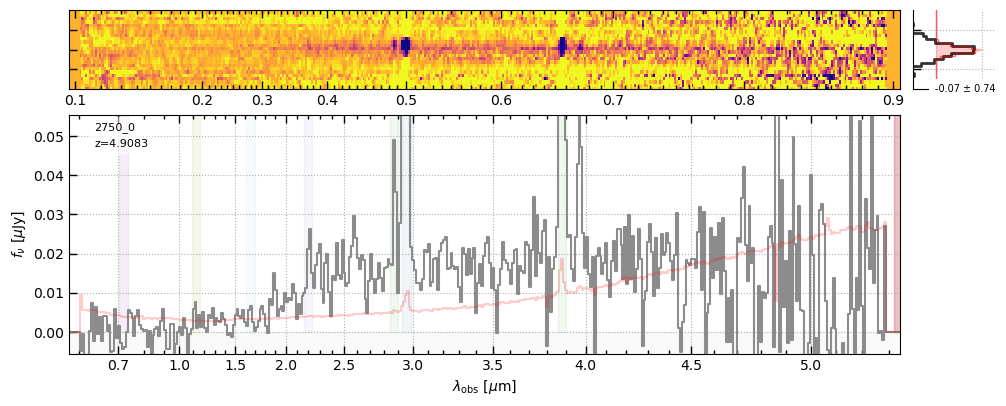

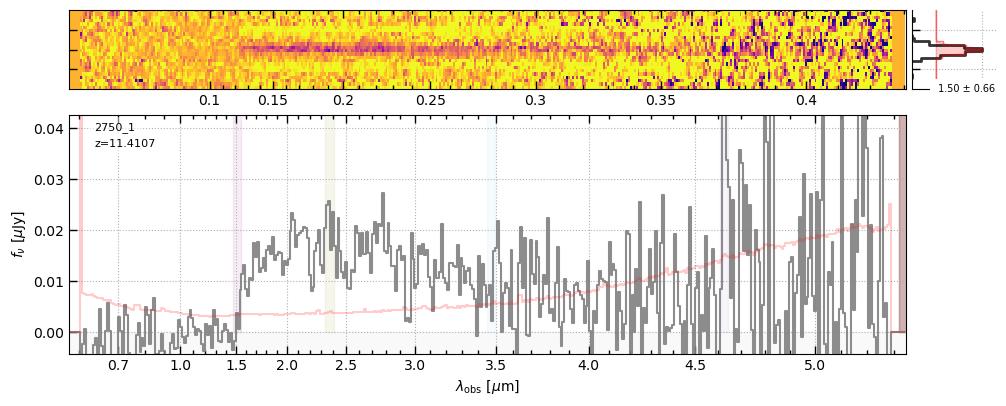

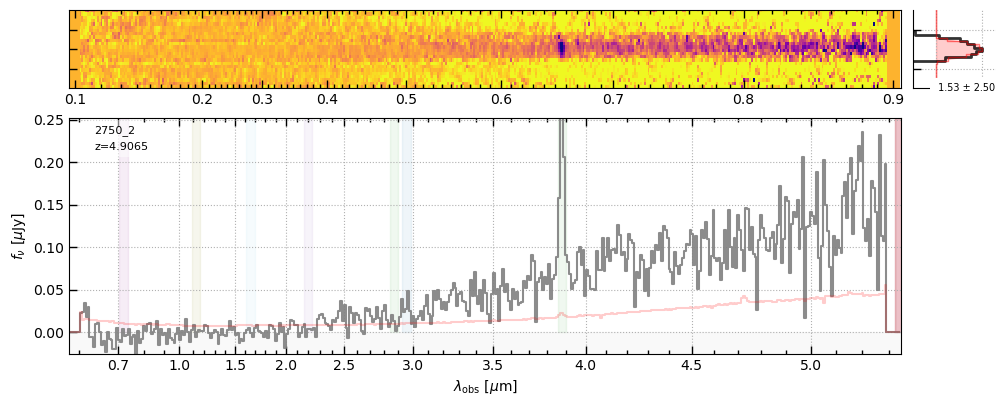

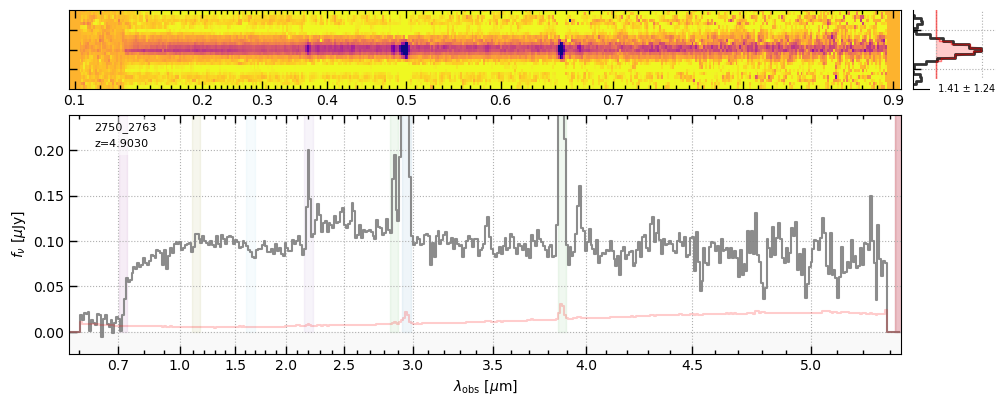

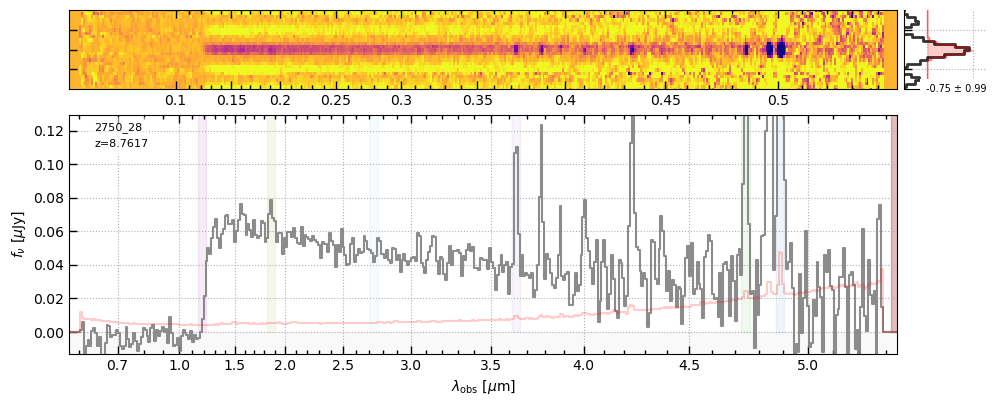

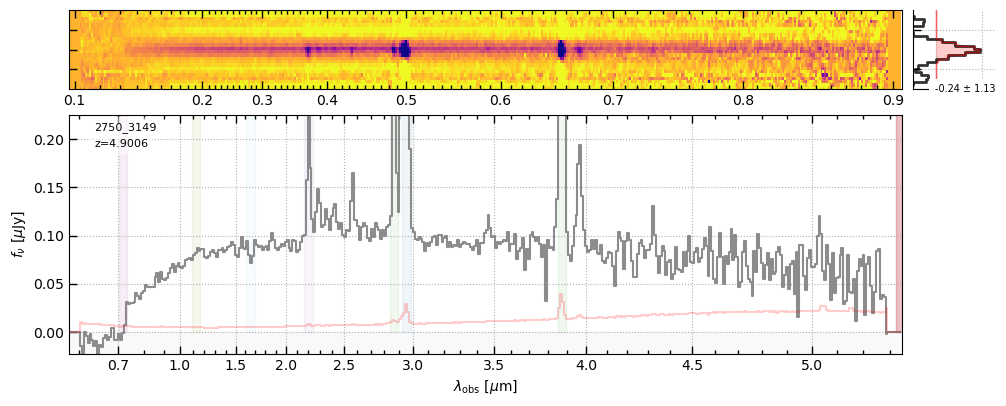

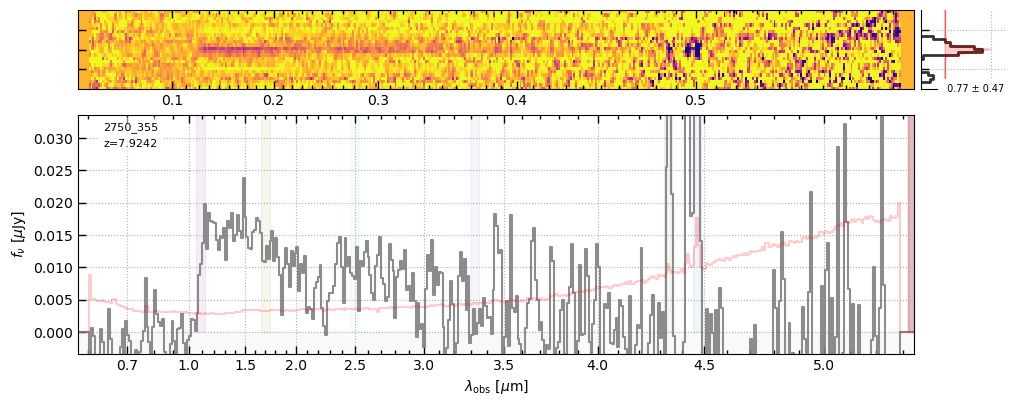

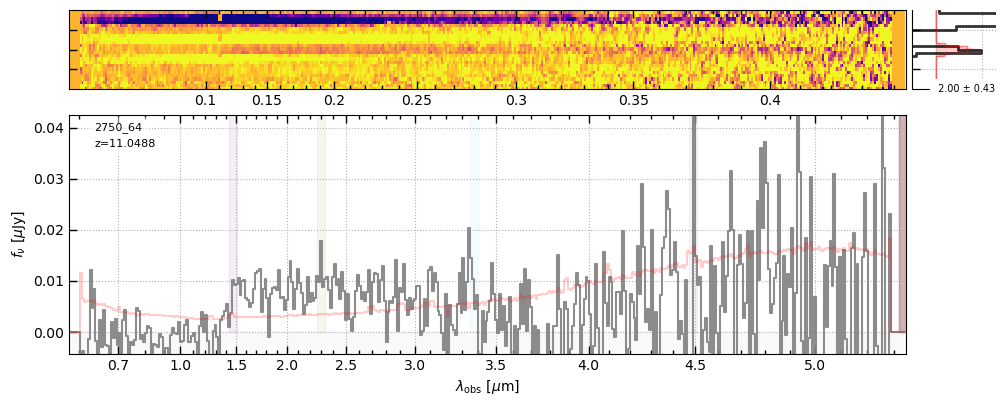

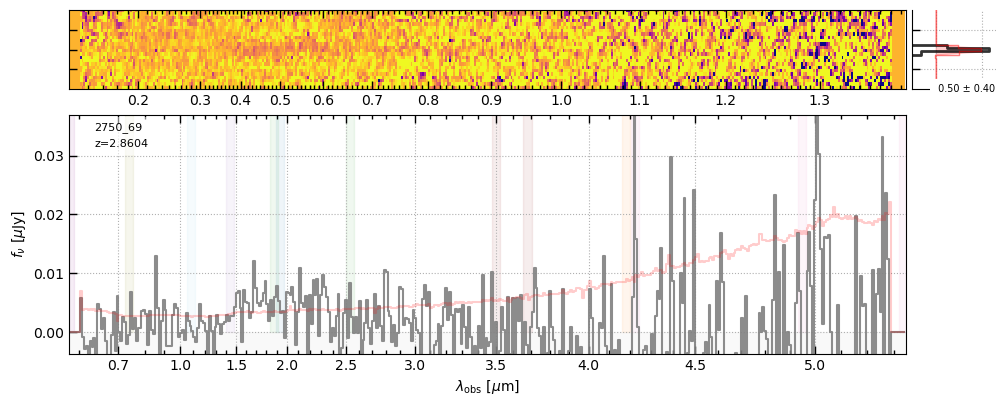

In [39]:
# Show the final figures
for target in targets:
    with pyfits.open(f'{outroot}_{target}.{file_version}.spec.fits') as outhdu:
        best_z = outhdu['SPEC1D'].header['Z']
        fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu', z=best_z)
    

In [40]:
print(break)

SyntaxError: invalid syntax (1126903501.py, line 1)

# Redo with all sources

In [ ]:
from importlib import reload
reload(pipeline); reload(msaexp.msa)
reload(pipeline); reload(msaexp.msa)

source_ids = None

# Subset from Arrabal-Haro et al.
source_ids = [0, 1,2,28,64,69,355,2763,3149]

# All sources
msa = msaexp.msa.MSAMetafile('jw02750002001_01_msa.fits')
source_ids = list(np.unique(msa.shutter_table['source_id'][msa.shutter_table['primary_source'] == 'Y']))

for mode in groups:
    # Find the matching source
    pipe = pipeline.NirspecPipeline(mode=mode, files=groups[mode])

    idx, dr = src_rd.match_to_catalog_sky(pipe.msa.src_table)
    
    srcid = pipe.msa.src_table['source_id'][np.argmin(dr)]
    
    print(f'\n {mode} \n source_id: {srcid} dr={dr.min()}\n\n')

    # Run the pipeline to define slits, etc., but don't do extractions yet.  
    
    if 1:
        pipe = pipeline.NirspecPipeline(mode=mode,
                                        files=groups[mode],
                                        source_ids=source_ids,
                                        positive_ids=True # Ignore background slits
                                       ) 

        pipe.full_pipeline(run_extractions=False,
                           initialize_bkg=False,
                           load_saved=None,
                           scale_rnoise=False)

        pipes.append(pipe)

    else:
        print(f'Skip preprocessing: {pipe.mode}')

In [ ]:
# Re-initialize by reading the saved slitlet files

from importlib import reload
import msaexp.drizzle
reload(msaexp.pipeline); reload(msaexp.utils); reload(msaexp.drizzle)

targets = None

pipes = []

for mode in groups:
    
    if not os.path.exists(f'{mode}.slits.yaml'):
        continue
        
    pipe = pipeline.NirspecPipeline(mode=mode,
                                    files=groups[mode],
                                   ) 

    pipe.full_pipeline(run_extractions=False,
                       initialize_bkg=True,
                       load_saved='phot',
                       scale_rnoise=False,
                       targets=targets)

    #pipe.set_background_slits()
    print(f'\n\n {mode} {len(pipe.slitlets)} slitlets\n\n')
    
    if len(pipe.slitlets) > 0:
        pipes.append(pipe)


In [ ]:
targets = []
for pipe in pipes:
    targets += list(pipe.slitlets.keys())

ii = -1

targets = np.unique(targets)
targets

In [ ]:
for key in targets[:]:
    try:
        outhdu, zfit, fig = run_everything(key)
    except:
        pass
    